# Описание

- Задача: 
1. Посмотреть на компетенции студентов в разрезе желаемой роли в проекте. 
2. Составить словарик технологий для роли
3. Получить удельный вес технологии для роли (как доп признак при распределении по командам)
4. Выделить ключевые технологии внутри роли
- Ожидаемый результат: map(компетенция-роль)
- Вывод:

# План исследования

1. Подготовка данных
2. Исследование данных: оценка корреляции данных
3. Кластеризация данных
4. Оценка компетенций для роли?
5. Посмотреть роли в кот "хочу участвовать" и "Интересно попробовать"

# TODO:
1. дропать списки технологий, не относящихся к роли?

# Вопросы

1. Есть ли трендовые технологии?
2. Есть ли отклонения или несоответствия в технологиях внутри одной роли? 
3. Есть ли разделяемость внутри узких ролей

# Возникшие вопросы:
1. Рассматривать роли с максимальным приоритетом или все неотрицательные? - посмотреть все
2. Аномалии - скиловые студенты?

In [137]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [138]:
df = pd.read_excel("data_reassembled_4.xlsx")
df.head()

,Отметка времени,"Единая учетная запись СПбГУ (например, ST000000)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]","Выберете интересующие Вас роли, в IT [Анализ и инженерия данных]","Выберете интересующие Вас роли, в IT [Backend - разработка]","Выберете интересующие Вас роли, в IT [Frontend - разработка]","Выберете интересующие Вас роли, в IT [Тестирование и обеспечение качества]","Выберете интересующие Вас роли, в IT [Развертывание и внедрение]","Выберете интересующие Вас роли, в IT [Управление командой / проектом]",...,Оцените Ваш уровень мотивации [Устроиться на интересную для себя работу],"Хотите ли Вы общаться с другими студентами и выпускниками, заинтересованными в развитии в области IT на базе СПбГУ на интересующие Вас темы?","Что Вам поможет развиваться быстрее в том направлении деятельности, которое Вы выбрали?",Year,Season,score,hard_skills_score,soft_skills_score,directions,roles
0,2023-10-07 16:02:10.676,ST110311,3,1,1.0,1,1,3,1,3,...,3,2,NaN,2023,Осень,7.4,2.8,4.6,"['Web', 'NLP']",[]
1,2023-10-02 16:23:02.340,ST063118,1,3,1.0,5,3,3,3,3,...,4,1,"Опытные наставники, интересные задачи",2023,Осень,8.2,4.8,3.4,"['Time Series', 'DS', 'Robotics']",['backend developer']
2,2023-09-15 19:00:59.596,ST114946,1,3,1.0,3,5,3,1,1,...,3,2,Чёткий план действий,2023,Осень,8.3,4.7,3.6,"['CV', 'DS']",['frontend developer']
3,2023-09-11 14:35:19.227,ST112047,3,3,3.0,1,1,3,1,5,...,6,1,Прежний опыт в написанию проектов и любовь к р...,2023,Осень,8.5,3.5,5.0,"['Web', 'NLP', 'Robotics']",['pm']
4,2023-09-10 22:04:15.396,ST112471,1,1,1.0,1,1,3,1,5,...,1,1,Личный рост,2023,Осень,4.6,0.0,4.6,[],['pm']


In [139]:
tech_columns = [
    'Языки программирования (например: C++, Python, Java, etc)',
    'Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)',
    'Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)',
    'Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)',
    'Инструменты для тестирования  (например: GTests, Selenium, Gatling, pytest etc)',
    'Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)',
    'Инструменты для управления проектами (например: Jira, Trello, MS Project, etc) '
]

In [140]:
role_columns = [
    'Выберете интересующие Вас роли, в  IT [Бизнес и системный анализ]', 
    'Выберете интересующие Вас роли, в  IT [Дизайн UX / UI и проектирование интерфейсов]',
    'Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]', 
    'Выберете интересующие Вас роли, в  IT [Backend - разработка]', 
    'Выберете интересующие Вас роли, в  IT [Frontend - разработка]',
    'Выберете интересующие Вас роли, в  IT [Тестирование и обеспечение качества]',
    'Выберете интересующие Вас роли, в  IT [Развертывание и внедрение]',
    'Выберете интересующие Вас роли, в  IT [Управление командой / проектом]',
    'roles'
]

In [141]:
new_df = df[[
    'Единая учетная запись СПбГУ (например, ST000000)',
    'Языки программирования (например: C++, Python, Java, etc)',
    'Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)',
    'Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)',
    'Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)',
    'Инструменты для тестирования  (например: GTests, Selenium, Gatling, pytest etc)',
    'Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)',
    'Инструменты для управления проектами (например: Jira, Trello, MS Project, etc) ',
    'Выберете интересующие Вас роли, в  IT [Бизнес и системный анализ]', 
    'Выберете интересующие Вас роли, в  IT [Дизайн UX / UI и проектирование интерфейсов]',
    'Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]', 
    'Выберете интересующие Вас роли, в  IT [Backend - разработка]', 
    'Выберете интересующие Вас роли, в  IT [Frontend - разработка]',
    'Выберете интересующие Вас роли, в  IT [Тестирование и обеспечение качества]',
    'Выберете интересующие Вас роли, в  IT [Развертывание и внедрение]',
    'Выберете интересующие Вас роли, в  IT [Управление командой / проектом]',
    'roles'
]]


In [142]:
# Разделение строк на отдельные термины и получение уникальных значений
unique_roles = set()
for row in new_df['roles']:
    terms = eval(row) # strip("[]").replace("'", "").split(', ') 
    unique_roles.update(terms)

print(unique_roles)

{'qa', 'implementation', 'backend developer', 'system or business analyst', 'pm', 'frontend developer', 'ux/ui', 'da or de'}


In [143]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 17 columns):
 #   Column                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                              --------------  -----  
 0   Единая учетная запись СПбГУ (например, ST000000)                                                                    349 non-null    object 
 1   Языки программирования (например: C++, Python, Java, etc)                                                           346 non-null    object 
 2   Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)  309 non-null    object 
 3   Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)              106 non-null    object 
 4   Инструменты для разр

In [144]:
new_df.loc[:, tech_columns] = new_df.loc[:, tech_columns].astype(str)

/var/folders/89/q6t8y6z56vl91ct9zt_gb56h0000gn/T/ipykernel_88568/3696747570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.loc[:, tech_columns] = new_df.loc[:, tech_columns].astype(str)


In [145]:
from functions_for_clustering import *
tech_df = collect_competency_matrix(new_df, tech_columns)

In [146]:
result_df = pd.concat([new_df, tech_df], axis=1)
result_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
0,ST110311,Python - 2,Numpy - 1,nan,nan,nan,nan,nan,3,1,...,0,0,0,0,0,0,0,0,0,0
1,ST063118,C# - 4\nC - 3\nC++ - 2\nPython - 3,ASP.NET - 4\nBlazor - 4\nNumpy - 3\nQt - 2,,Rider - 4\nGit - 4\nPyCharm - 3\nSVN - 2,,Docker - 4,Trello - 2\nGitLab - 4,1,3,...,0,0,0,0,0,0,0,0,0,0
2,ST114946,C++ - 3\nJava - 3\nC# - 2\nPython - 3\nJavaScr...,Django - 3\nBoost - 3\nQt - 2\nSpring - 3\nMav...,Microsoft Visio - 2\nUML - 2\nSAP - 3\nBPMN - 2,GitHub - 3\nVS Code - 3\nAzure - 2\nDocker - 2...,GTests - 2\nJira - 3 \nGatling - 2,Jenkins - 3\nGitHub actions -2\nGitLab CI - 2,Jira- 3\nMS Project - 2\nJetbrains teamcity - 2,1,3,...,3,0,0,2,0,0,0,0,0,0
3,ST112047,Python 3,Numpy 3,-,-,-,-,-,3,3,...,0,0,0,0,0,0,0,0,0,0
4,ST112471,1,2,1,1,1,Я,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [147]:
result_df.fillna(0, inplace=True)

## Корреляции

In [148]:
# # Проверка корреляции между двумя колонками
# корреляция = df['Колонка1'].corr(df['Колонка2'])

# print(f"Корреляция между Колонка1 и Колонка2: {корреляция}")

In [149]:
c = result_df['python'].corr(result_df['Выберете интересующие Вас роли, в  IT [Backend - разработка]'])

print(f"Корреляция между python и Колонка2: {c}")

Корреляция между python и Колонка2: 0.06875811932829579


In [150]:
d = result_df['python'].corr(result_df['Выберете интересующие Вас роли, в  IT [Анализ и инженерия данных]'])

print(f"Корреляция между python и Колонка2: {d}")

Корреляция между python и Колонка2: 0.19293130697678007


/var/folders/89/q6t8y6z56vl91ct9zt_gb56h0000gn/T/ipykernel_88568/1194253333.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = result_df.corr()


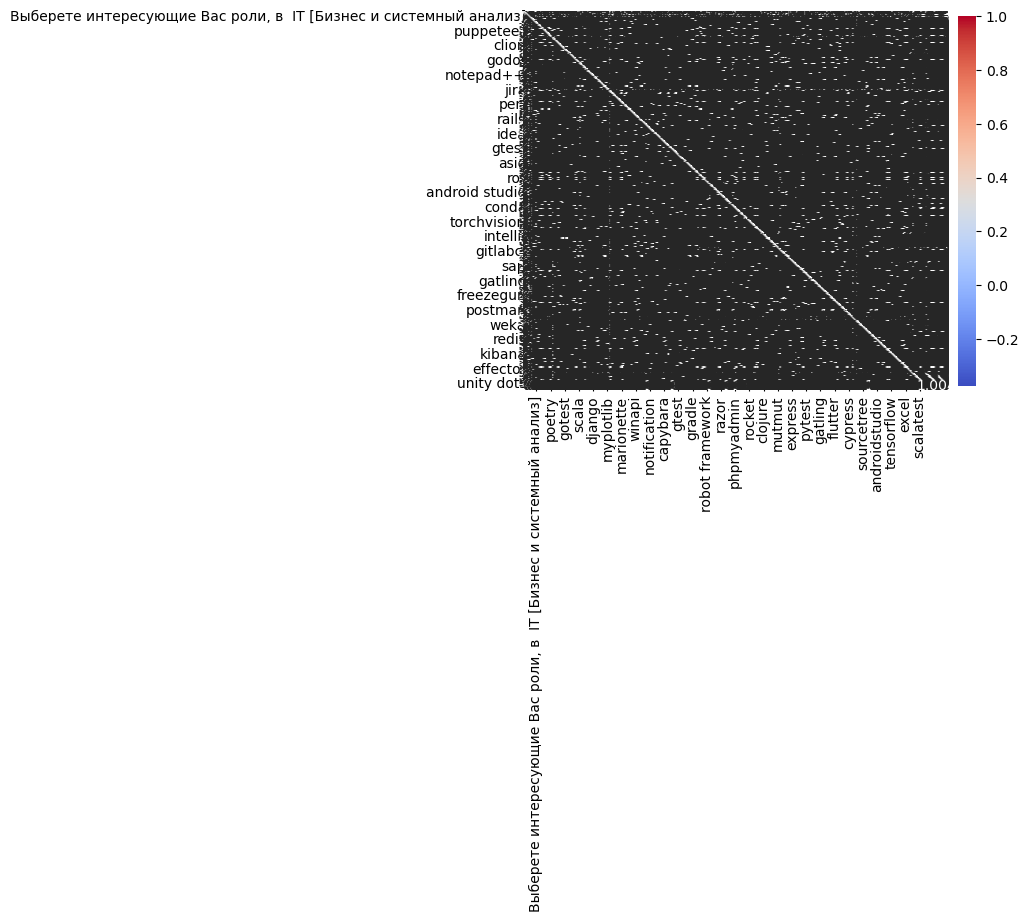

In [151]:
corr_matrix = result_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [152]:
corr_matrix_roles = corr_matrix.iloc[:8, 8:]

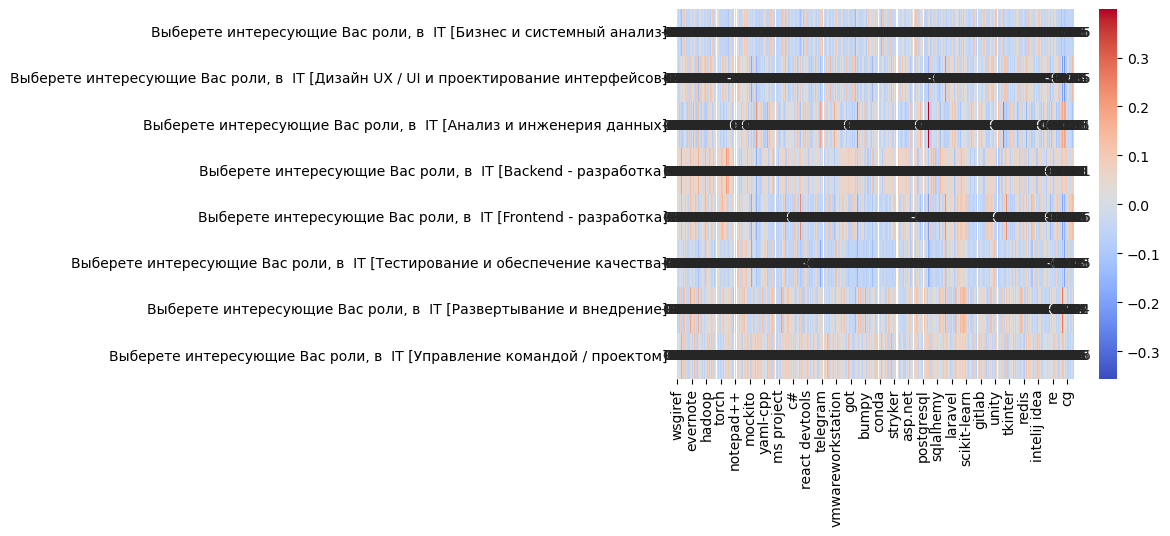

In [153]:
sns.heatmap(corr_matrix_roles, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [154]:
corr_matrix_roles.head()

,wsgiref,gitactions,tokio-rs,rspec,lua,c++,mindmeister,make,spring security,yii,...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
"Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]",0.030191,-0.048148,-0.008979,-0.067770,-0.064672,-0.133444,-0.008979,-0.048148,-0.023346,0.108529,...,-0.048319,-0.008979,0.108529,-0.048148,-0.048148,-0.048148,NaN,-0.048148,-0.057234,-0.048148
"Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",0.028036,-0.047813,-0.047813,-0.067299,0.003698,0.061494,0.065961,0.028036,-0.066393,0.028036,...,-0.080637,0.065961,0.028036,0.028036,-0.047813,-0.047813,NaN,-0.047813,0.142205,-0.047813
"Выберете интересующие Вас роли, в IT [Анализ и инженерия данных]",0.076313,0.014590,-0.077993,-0.027728,-0.021854,-0.085380,-0.077993,-0.047132,-0.065447,0.014590,...,-0.036045,-0.077993,0.014590,-0.047132,0.014590,-0.047132,NaN,-0.047132,-0.112300,0.076313
"Выберете интересующие Вас роли, в IT [Backend - разработка]",0.057709,0.057709,0.057709,0.037931,0.077514,0.193443,0.023103,0.057709,0.080134,0.057709,...,0.098639,0.023103,0.057709,-0.011502,-0.011502,-0.011502,NaN,-0.011502,0.079441,-0.011502
"Выберете интересующие Вас роли, в IT [Frontend - разработка]",0.009676,0.009676,0.077218,-0.039195,0.043238,0.144512,0.043447,0.009676,-0.042836,0.009676,...,-0.029864,0.043447,0.009676,0.077218,-0.057865,0.077218,NaN,-0.057865,0.146974,-0.057865


In [155]:
# путь и имя файла Excel, в который запишем данные
excel_file = 'corr_matrix.xlsx'

# Запись данных в Excel
corr_matrix.to_excel(excel_file)  # Установить index=False, чтобы не сохранять индексы

### Список (знач.корр, строка, столбец)

In [156]:
def find_great_corr(c_matrix, k=0.5):
    corr_list = []
    for i_row, row_name in c_matrix.iterrows():
        for j_column, v in row_name.items():
            if abs(v) > k and i_row != j_column: 
                # print(v)
                temp = (v, i_row, j_column)
                corr_list.append(temp)
    print("Список значений корреляций:")
    for tuple in corr_list:
        print(tuple) 
    return corr_list

In [157]:
find_great_corr(corr_matrix_roles, k=0.6)

Список значений корреляций:


[]

In [158]:
corr_matrix_techs = corr_matrix.iloc[8:, 8:]

In [159]:
corr_tech_list = find_great_corr(corr_matrix_techs, 0.8)
print(len(corr_tech_list))

Список значений корреляций:
(1.0, 'tokio-rs', 'google test')
(1.0, 'tokio-rs', 'ncurses')
(0.9999999999999999, 'tokio-rs', 'clap-rs')
(0.9999999999999999, 'tokio-rs', 'gtk')
(1.0, 'tokio-rs', 'rayon')
(0.9999999999999999, 'tokio-rs', 'diesel-rs')
(0.8941704679675253, 'lua', 'glfw')
(0.8941704679675253, 'lua', 'robot framework')
(0.8941704679675253, 'lua', 'bullet')
(1.0, 'mindmeister', 'sublimetext')
(1.0, 'mindmeister', 'coggle')
(1.0, 'mindmeister', 'vsc')
(1.0, 'mindmeister', 'webstrom')
(1.0, 'mindmeister', 'croller')
(1.0, 'mindmeister', 'mpandroidchart')
(0.9999999999999994, 'make', 'socket.io')
(0.8315599251931581, 'spring security', 'spring jdbc')
(1.0000000000000002, 'yii', 'cd')
(1.0, 'yii', 'psutil')
(1.0, 'yii', 'loguru')
(1.0, 'yii', 'gitea')
(1.0000000000000002, 'yii', 'mutmut')
(0.9701016978952147, 'yii', 'laravel')
(1.0, 'yii', 'plantuml')
(1.0, 'yii', 'alembic')
(1.0, 'yii', 'ahk')
(1.0, 'poetry', 'tortoise')
(0.9999999999999992, 'poetry', 'sentry')
(1.0, 'poetry', 'po

In [160]:
python_corr_list = find_great_corr(pd.DataFrame(corr_matrix_techs['python']), 0.5)
print(len(python_corr_list))

Список значений корреляций:
(0.6990542477889776, 'numpy', 'python')
(0.5526700198023076, 'pycharm', 'python')
2


# Кластеризация в разрезе желаемых ролей

In [161]:
qa_techs = extract_specific_features("test_tools.txt")
sa_ba_techs = extract_specific_features("analysis_tools.txt")
pm_techs = extract_specific_features("project_management_tools.txt")
imp_techs = extract_specific_features("CI_CD.txt")

languages = extract_specific_features("languages.txt")
frameworks = extract_specific_features("frameworks.txt")
dev_tools = extract_specific_features("dev_tools.txt")

## Backend developer

Необходимо рассмотреть все желаемые роли студента или взять максимальную

In [162]:
# Выборка строк, в которых 'backend developer' присутствует в списке ролей
backend_df = result_df[result_df['roles'].str.contains('backend developer')]

backend_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
1,ST063118,C# - 4\nC - 3\nC++ - 2\nPython - 3,ASP.NET - 4\nBlazor - 4\nNumpy - 3\nQt - 2,,Rider - 4\nGit - 4\nPyCharm - 3\nSVN - 2,,Docker - 4,Trello - 2\nGitLab - 4,1,3,...,0,0,0,0,0,0,0,0,0,0
9,ST115982,C# - 4\nC++ - 2\nPython - 2\nJava - 1\nPython ...,Numpy - 2\nPandas - 2\nMatplotlib - 2\nPyTorch...,\n,Visual studio - 4\nUnity - 4\nPycharm - 2\nGit...,\n,\n,\n,1,1,...,0,0,0,0,0,0,0,0,0,0
14,ST110470,"Python - 4,\nJS - 2",AIOgram - 4\nDjango - 4,-,VS Code - 5\nGit -4,pytest - 3/4,Docker - 4,Notion -4,3,1,...,0,0,0,0,0,0,0,0,0,0
17,ST090662,"Python - 3, c++ - 2, c# - 1","FastAPI - 3, Django - 3",nan,"Git - 3, PyCharm - 3",pytest - 2,Docker - 3,Jira - 3,1,1,...,0,0,0,0,0,0,0,0,0,0
19,ST115985,C++ - 3\nPython - 2,Qt - 1\nAngular - 1,nan,Git - 3\nPyCharm - 2\nVS Code - 2,Selenium - 1\nPytest - 1,Jenkins - 3\nDocker - 3,nan,1,1,...,0,0,0,0,0,0,0,0,0,0


#### DBSCAN

In [163]:
# backend_df.set_index('Единая учетная запись СПбГУ (например, ST000000)', inplace=True)
backend_df = backend_df.drop(tech_columns, axis=1)
backend_df = backend_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
backend_df = backend_df.drop(role_columns, axis=1)

drop_set = set (qa_techs + sa_ba_techs+ pm_techs+ imp_techs + dev_tools)
backend_df = backend_df.drop(drop_set, axis=1)
# # backend_df = backend_df.drop(sa_ba_techs, axis=1)
# backend_df = backend_df.drop(pm_techs, axis=1)
# backend_df = backend_df.drop(imp_techs, axis=1)

In [164]:
# backend_columns = list(languages, frameworks, dev_tools)
# backend_df = backend_df[backend_columns]

In [165]:
backend_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1 to 347
Columns: 283 entries, wsgiref to redux
dtypes: int64(283)
memory usage: 343.9 KB


In [166]:
backend_df.head()

,wsgiref,tokio-rs,lua,c++,spring security,yii,ruby on rails,opencv,koa,php,...,reason ml,ruby,python,spring,cg,krl,next.js,pyhton,unity dots,redux
1,0,0,0,2,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
9,0,0,0,2,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
17,0,0,0,2,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
19,0,0,0,3,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0


Чистим от "нулевых" колонок

In [167]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = backend_df.columns[backend_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

backend_df = backend_df.drop(zero_columns, axis=1)


Колонки с нулевыми значениями: ['beautifulsoup', 'nemo', 'razdel', 'arduino c', 'ember', 'xgboost', 'nympy', 'twint', 'snakemake', 'quill', 'coroutines', 'custom view', 'nextjs', 'j', 'matematica', 'phython', 'npm', 'rxjs', 'aiohttp', 'pyplot', 'vulkan', 'sklearn', 'yaml-cpp', 'lightfm', 'pyav', 'mediapipe', 'notification', 'apispec', 'sdml', 'play', 'typing', 'zenject', 'folium', 'opevcv', 'gdi+', 'implicit', 'storybook', 'sanic', 'ror', 'reactivex', 'razor', 'asp.net mvc framework', 'catboost', 'bumpy', 'rxjava', 'asp.net core', 'elasticsearch', 'symphony', 'addressables', 'streamlit', 'material design', 'spark', 'winforms', 'gephi', 'prisma', 'lightgbm', 'hascell', 'volley', 'next', 'jetpack compose', 'firebase', 'sqlalhemy', 'huggingface', '.net', 'reactnative', 'antlr', 'wandb', 'networkx', 'r', 'prophet', 'google play console', 'recyclerview', 'framer-motion', 'scss', 'jquery', 'fragments', 'net', 'nltk', 'geocoder', 'plotly', 'kafka', 'surprise', 'arduino', 'mavlink', 'flow', 'a

In [168]:
data_backend = backend_df.values
data1 = backend_df.values

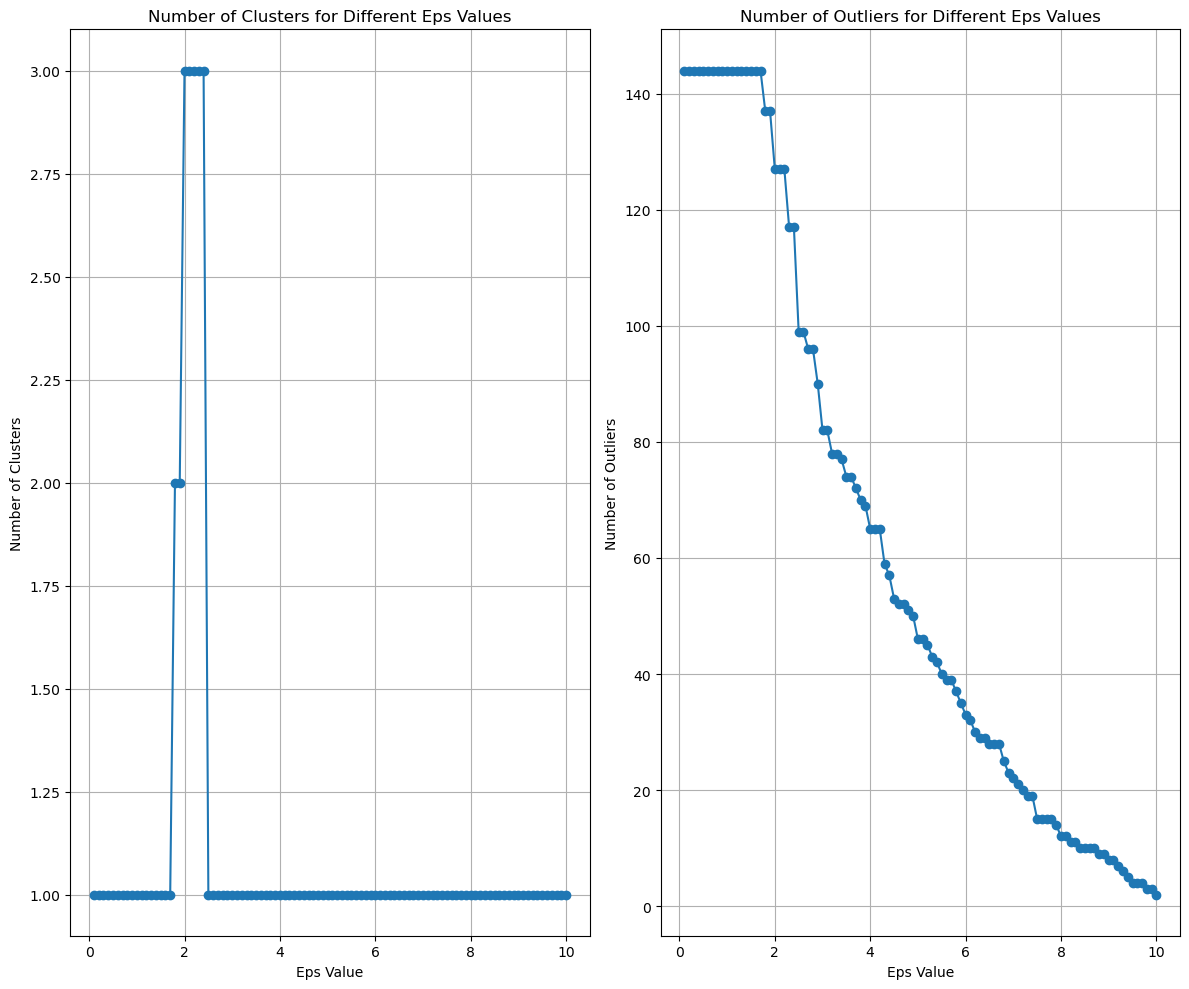

In [169]:
find_parameters_for_DBSCUN(0.1, 10.0, 100, data_backend)

2 кластера + много выбросов

In [170]:
dbscan = DBSCAN(eps=2.3, min_samples=5)
dbscan.fit(data_backend)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


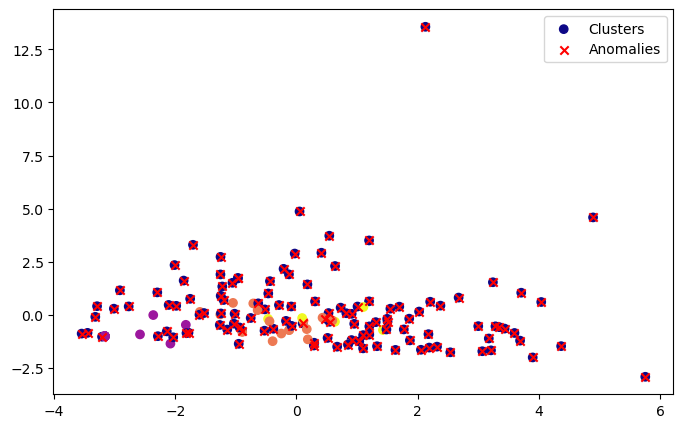

In [171]:
draw_clusters(data_backend, cluster_labels, is_anomaly)

In [172]:
count_points_in_clusters(cluster_labels)

Кластер 0: 15 точек
Кластер 1: 18 точек
Кластер 2: 5 точек
Кластер -1: 117 точек


In [173]:
# # Пример использования функции
# data = ...  # исходные данные (матрица данных)
# cluster_labels = ...  # Метки кластеров, полученные после кластеризации
# all_technologies = ...  # Названия всех колонок

analyze_clusters(data1, cluster_labels, backend_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['chi', 'assembler', 'react', 'javascript', 'redux'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['pydantic', 'c#', 'java', 'numpy', 'c++'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['matplotlib', 'python', 'java', 'numpy', 'c++'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['java', 'c#', 'c++', 'python', 'numpy'], dtype='object')



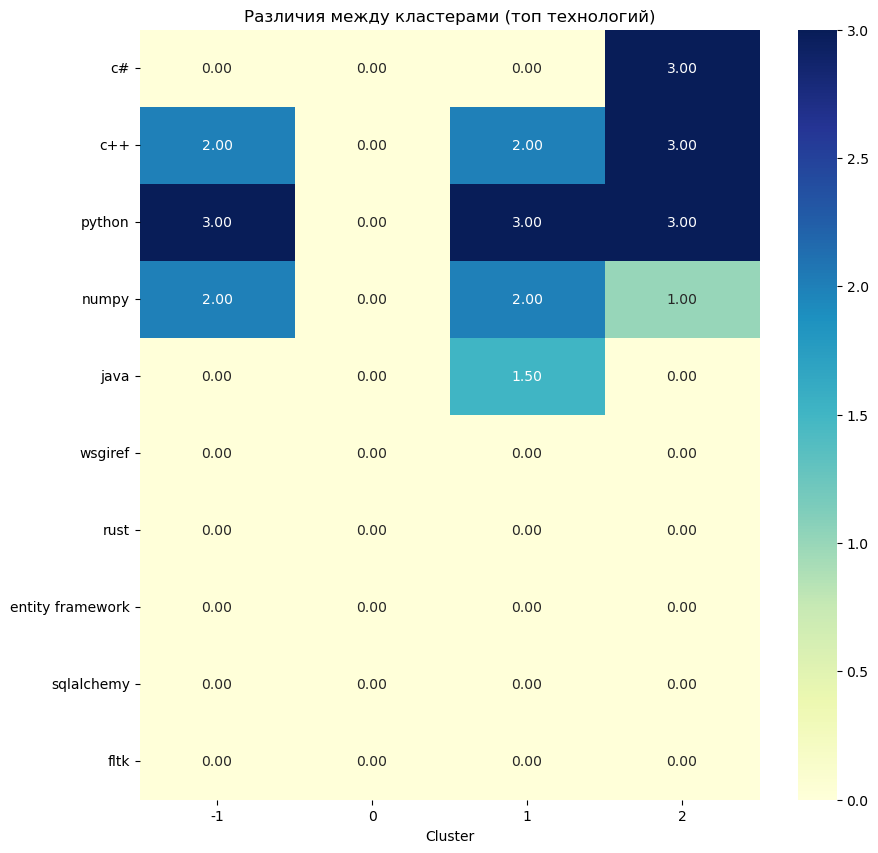

In [174]:
draw_heat_map(data_backend, backend_df.columns, cluster_labels)

**Вывод**: 
* Python + numpy, C++, java, c#, java 
* react, redux

In [175]:
backend_anomalies = backend_df[is_anomaly]
backend_anomalies.head()

,wsgiref,tokio-rs,lua,c++,spring security,yii,ruby on rails,opencv,koa,php,...,springweb,cobol,sas,swift ui,reason ml,ruby,python,spring,cg,redux
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
9,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4,0,0,0
17,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
19,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


Убираю 'python', 'c++', 'git', 'pycharm', 'numpy', потому что они мешают находить различия между группами

In [176]:
# backend_anomalies = backend_anomalies.drop(['python', 'c++', 'git', 'pycharm', 'numpy'], axis=1) 
# backend_anomalies = backend_anomalies.drop(dev_tools, axis=1)

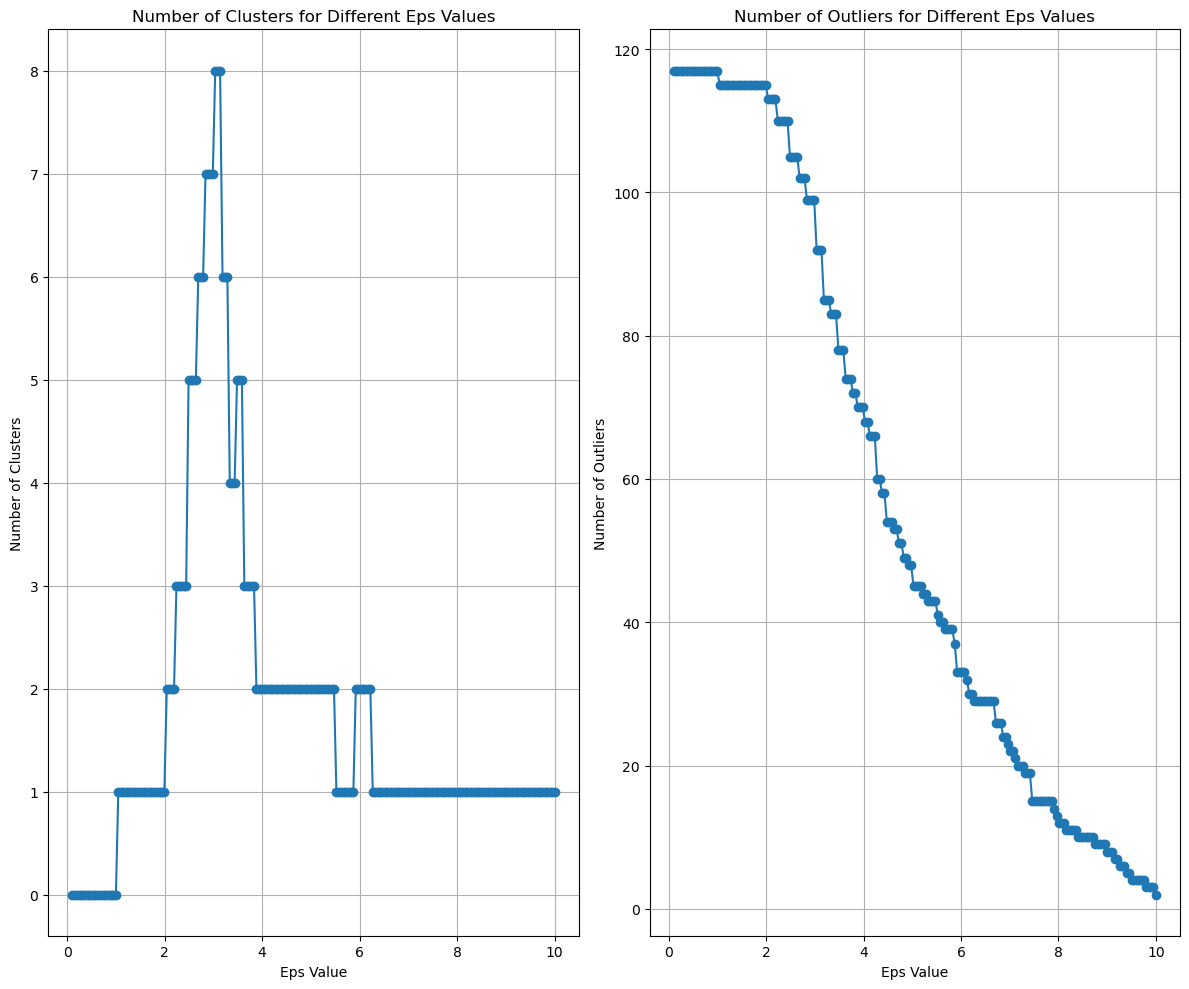

In [177]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, backend_anomalies, 2)

In [178]:
dbscan = DBSCAN(eps=3, min_samples=2)
dbscan.fit(backend_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 8


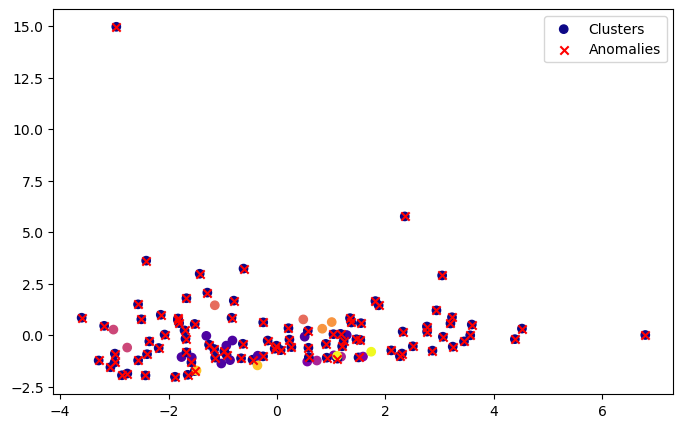

In [179]:
draw_clusters(backend_anomalies, cluster_labels, is_anomaly)

In [180]:
count_points_in_clusters(cluster_labels)

Кластер 0: 10 точек
Кластер 1: 3 точек
Кластер 2: 2 точек
Кластер 3: 2 точек
Кластер 4: 2 точек
Кластер 5: 2 точек
Кластер 6: 2 точек
Кластер 7: 2 точек
Кластер -1: 92 точек


In [181]:
analyze_clusters(backend_anomalies, cluster_labels, backend_anomalies.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['lxml', 'typescript', 'chi', 'c#', 'redux'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['scala', 'clojure', 'pandas', 'c++', 'c#'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['sfml', 'scipy', 'pandas', 'python', 'c++'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['numpy', 'ntlk', 'c++', 'wsgiref', 'python'], dtype='object')

Кластер 3:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['gdscript', 'cocoa', 'pydantic', 'redux', 'javascript'], dtype='object')

Кластер 4:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['javascript', 'c++', 'python', 'react', 'numpy'], dtype='object')

Кластер 5:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['c++', 'numpy', 'sqlalchemy', 'flask', 'python'], dtype='object')

Кластер 6:
Топ-10 колонок с наиб

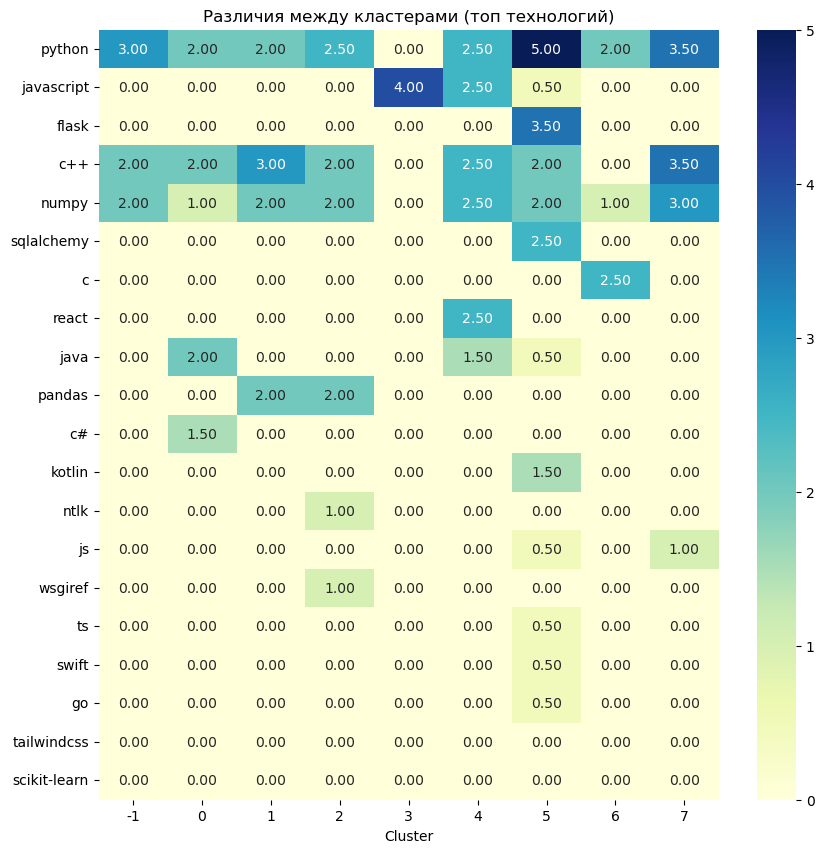

In [182]:
draw_heat_map(backend_anomalies, backend_anomalies.columns, cluster_labels, 20)

**Вывод по Backend-разработке:** основная масса желающих знает **Python** (+Fastapi, flask), **C++**, 
изредка встречаются java/kotlin (+spring), C#, JS + react, Swift/Objective-C, sqlalchemy, redux  

# DA or DE

In [183]:
# Выборка строк, в которых 'da or de' присутствует в списке ролей
da_de_df = result_df[result_df['roles'].str.contains('da or de')]

da_de_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
5,ST069808,Python - 4\nPHP - 3\nJava - 2\nC++ - 2\nC# - 2,Numpy - 3\nPyTorch - 2\nscipy - 3,UML - 3,PyCharm - 4\nGit - 4,pytest - 2,Docker - 3,Jira - 3,3,1,...,0,0,0,0,0,0,0,0,0,0
16,ST077125,C++ - 2\nPython - 2\nSQL - 2,Numpy- 2\nPandas - 2,nan,Git - 2\nPyCharm - 2\nVisual Studio - 2,nan,nan,Trello - 3,1,1,...,0,0,0,0,0,0,0,0,0,0
19,ST115985,C++ - 3\nPython - 2,Qt - 1\nAngular - 1,nan,Git - 3\nPyCharm - 2\nVS Code - 2,Selenium - 1\nPytest - 1,Jenkins - 3\nDocker - 3,nan,1,1,...,0,0,0,0,0,0,0,0,0,0
31,ST069636,Python - 5,Numpy - 5\nPyTorch - 4\nPandas - 5\nPlotly - 4...,nan,VS Code - 5\nGit - 4,Pytest - 3,Docker - 3,Trello - 3\nAsana - 3,1,1,...,0,0,0,0,0,0,0,0,0,0
36,ST095276,С++ - 2\nJava - 2\nPython - 3\nSQL - 2\n,Numpy - 3\nPandas - 4\nMatplotlib - 3\nSeaborn...,nan,VS Code - 4\nGit - 3,GTests - 2\n,Docker - 1\n,nan,5,3,...,0,0,0,0,0,0,0,0,0,0


In [184]:
da_de_df = da_de_df.drop(tech_columns, axis=1)
da_de_df = da_de_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
da_de_df = da_de_df.drop(role_columns, axis=1)

# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = da_de_df.columns[da_de_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())
da_de_df = da_de_df.drop(zero_columns, axis=1)

Колонки с нулевыми значениями: ['gitactions', 'tokio-rs', 'rspec', 'lua', 'mindmeister', 'make', 'spring security', 'yii', 'poetry', 'ruby on rails', 'puppeteer', 'koa', 'google test', 'solidity', 'd', 'rollup', 'nginx', 'gotest', 'swiftui', 'ncurses', 'arduino c', 'ember', 'handlebars', 'hadoop', 'nympy', 'quill', 'cocoa touch', 'qt creator', 'intellijidea', 'travis cl', 'pymongo', 'godot', 'torch', 'coroutines', 'mocha', 'emotion', 'phpstorm', 'github projects', 'custom view', 'monday.com', 'gitlab projects', 'nextjs', 'elm', 'j', 'notepad++', 'archimate', 'matematica', 'phython', 'npm', 'rxjs', 'cd', 'aiohttp', 'aris', 'sublimetext', 'mockito', 'fast api', 'podman', 'openshift', 'clap-rs', 'coggle', 'vulkan', 'marionette', 'basecamp', 'pivotaltracker', 'rider', 'glfw', 'anaconda jupyter notebook', 'yaml-cpp', 'factor', 'iis manager', 'svn', 'perl', 'node.js', 'gulp', 'mokito', 'winapi', 'yandex tank', 'bomardier', 'sublime text', 'ms project', 'vsc', 'spring jdbc', 'tf', 'psutil', '

In [185]:
data_da_de = da_de_df.values

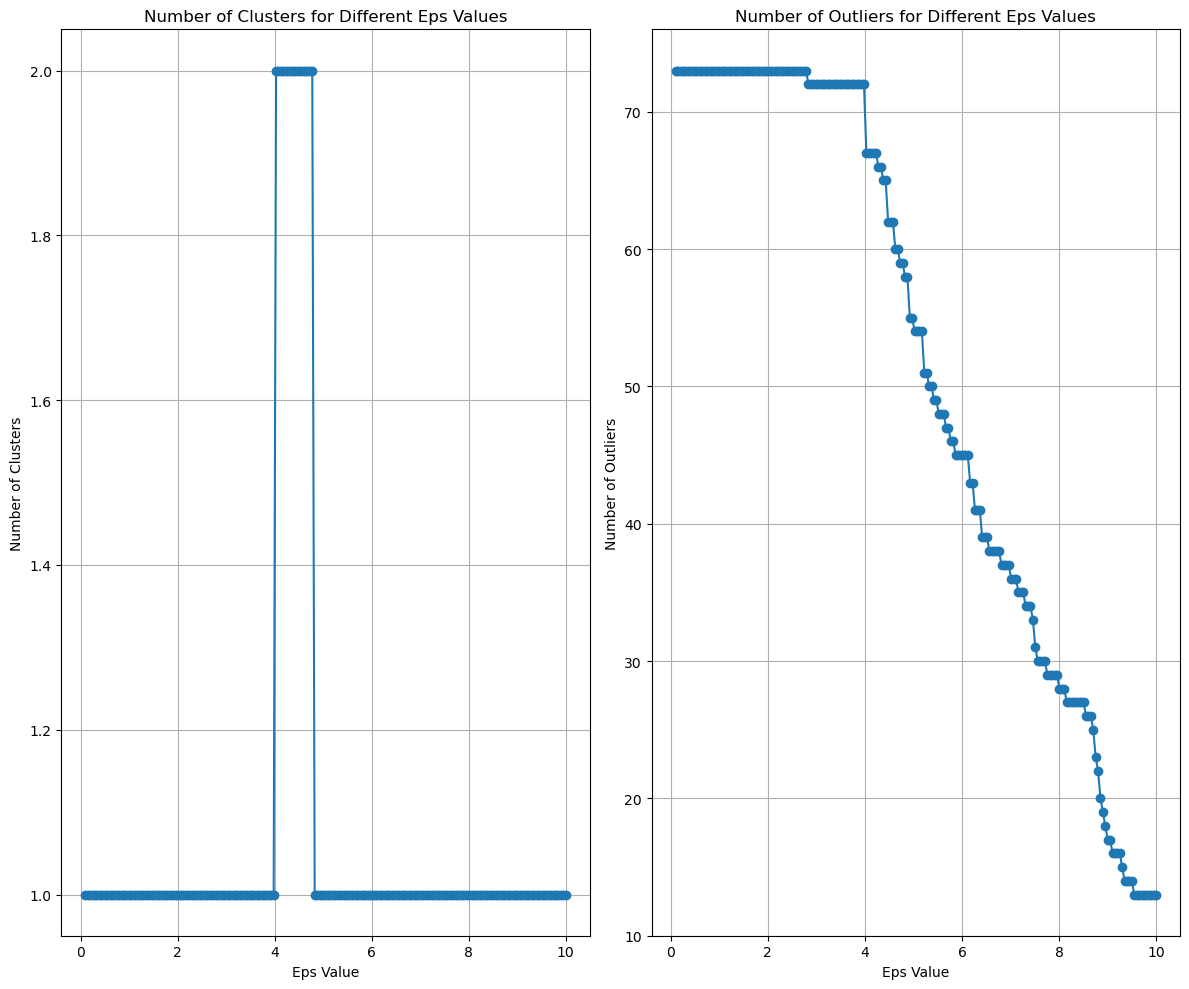

In [186]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_da_de, 5)

In [187]:
dbscan = DBSCAN(eps=4.3,  min_samples=5)
dbscan.fit(data_da_de)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


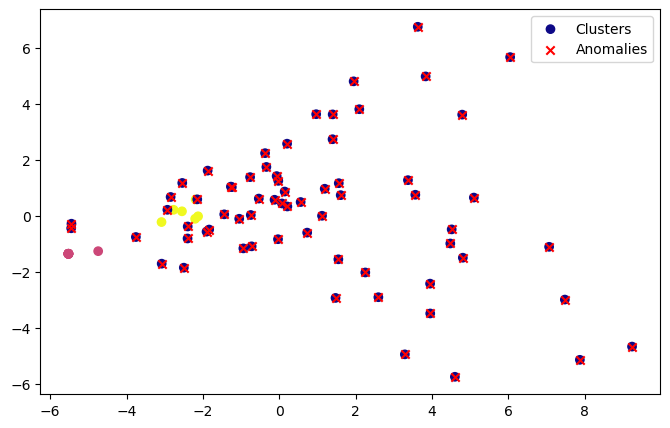

In [188]:
from functions_for_clustering import *  

draw_clusters(data_da_de, cluster_labels, is_anomaly)

In [190]:
analyze_clusters(data_da_de, cluster_labels, da_de_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['scikit-learn', 'scala', 'wandb', 'sklearn', 'pytest'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['folium', 'asana', 'jupyter lab', 'numpy', 'vscode'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['numpy', 'vs code', 'python', 'c++', 'pycharm'], dtype='object')



In [191]:
count_points_in_clusters(cluster_labels)

Кластер 0: 9 точек
Кластер 1: 6 точек
Кластер -1: 66 точек


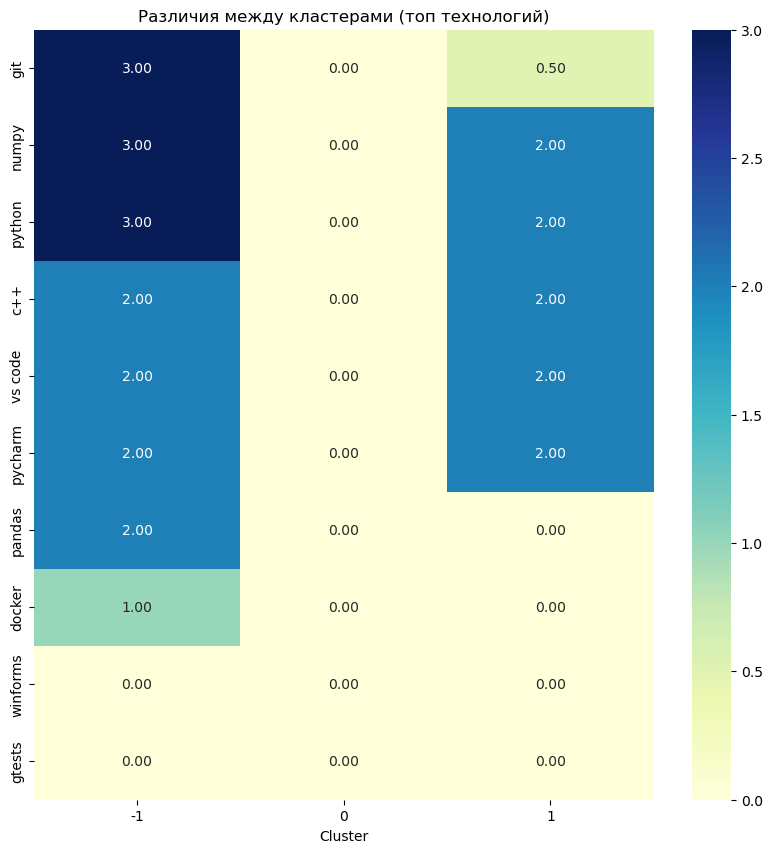

In [192]:
draw_heat_map(data_da_de, da_de_df.columns, cluster_labels)

Вывод по DS+DA: Python + numpy + pandas (folium, asana, jupiter lab), (c++, docker) 

## DA/DS anomalies

In [193]:
da_de_anomalies = da_de_df[is_anomaly]
da_de_anomalies.head()

,wsgiref,c++,opencv,collab,php,evernote,jenkins,beautifulsoup,nemo,git,...,pytorch lightning,sas,vs,scalatest,docker,notion,python,qt,spring,jupyter lab
5,0,2,0,0,3,0,0,0,0,4,...,0,0,0,0,3,0,4,0,0,0
16,0,2,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,2,0,0,0
19,0,3,0,0,0,0,3,0,0,3,...,0,0,0,0,3,0,2,1,0,0
31,0,0,0,0,0,0,0,0,0,4,...,4,0,0,0,3,0,5,0,0,0
36,0,2,0,0,0,0,0,0,0,3,...,0,0,0,0,1,0,3,0,0,0


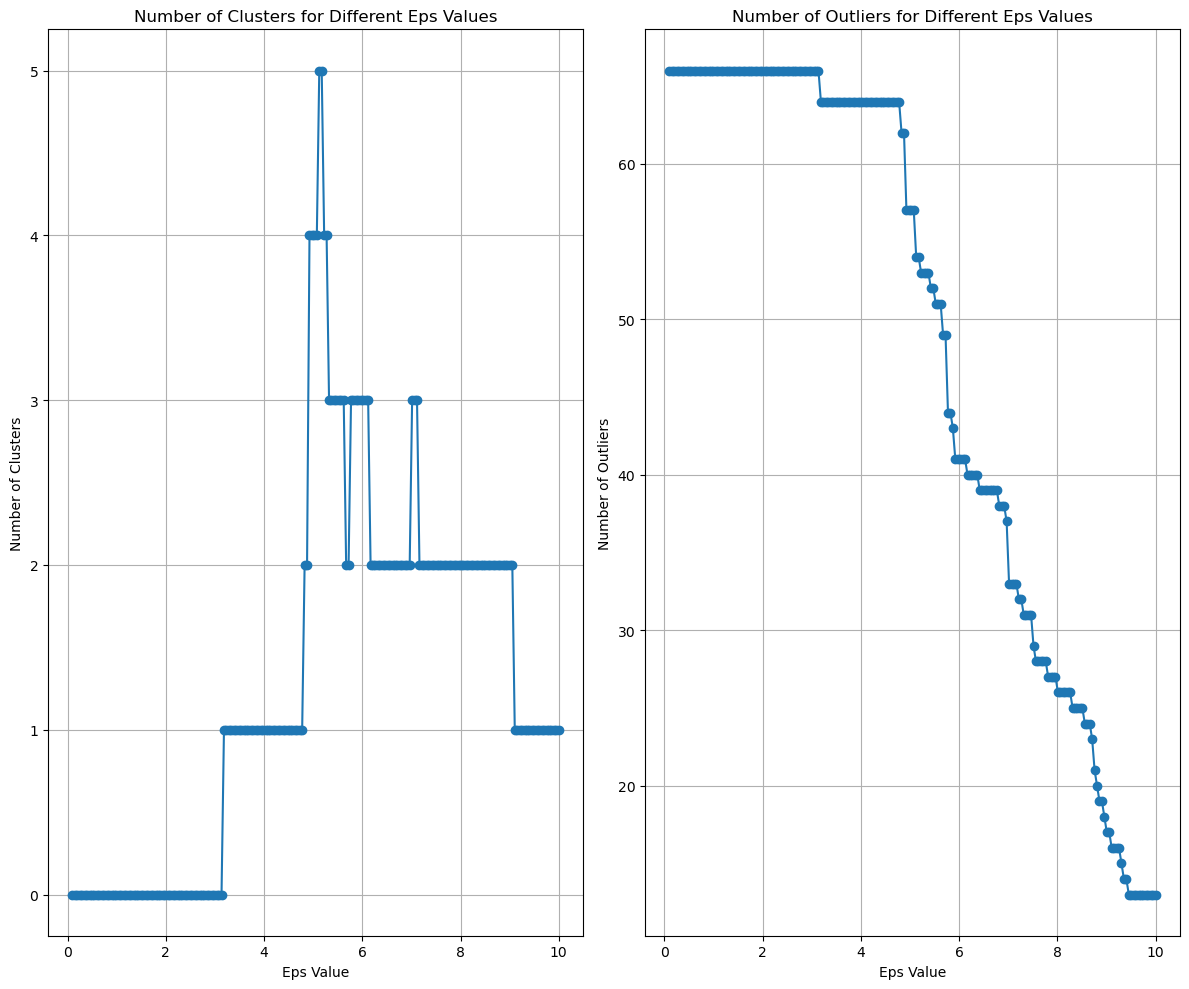

In [194]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, da_de_anomalies, 2)

In [195]:
dbscan = DBSCAN(eps=5.1, min_samples=2)
dbscan.fit(da_de_anomalies)
# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_
# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 5


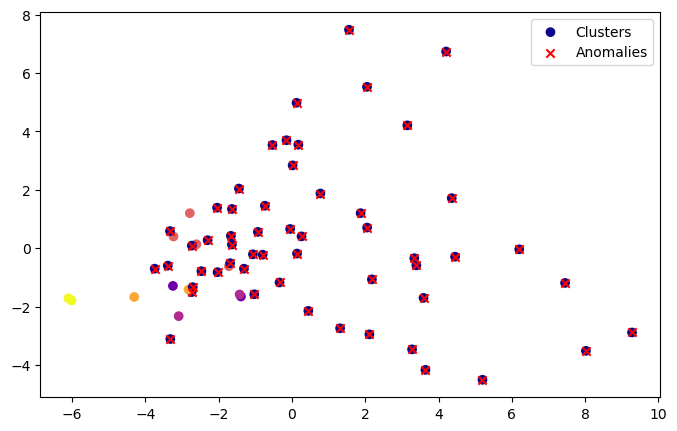

In [196]:
draw_clusters(da_de_anomalies, cluster_labels, is_anomaly)

In [197]:
analyze_clusters(da_de_anomalies, cluster_labels, da_de_anomalies.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['pandas', 'vs code', 'sql', 'matplotlib', 'pytest'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['numpy', 'ntlk', 'sql', 'jira', 'trello'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['numpy', 'pycharm', 'pytorch', 'python', 'vs code'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['visual studio', 'git', 'wsgiref', 'c++', 'python'], dtype='object')

Кластер 3:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['pycharm', 'pandas', 'vs code', 'sql', 'python'], dtype='object')

Кластер 4:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['gdi+', 'play', 'java', 'qt', 'c++'], dtype='object')



In [198]:
count_points_in_clusters(cluster_labels)

Кластер 0: 2 точек
Кластер 1: 2 точек
Кластер 2: 4 точек
Кластер 3: 2 точек
Кластер 4: 2 точек
Кластер -1: 54 точек


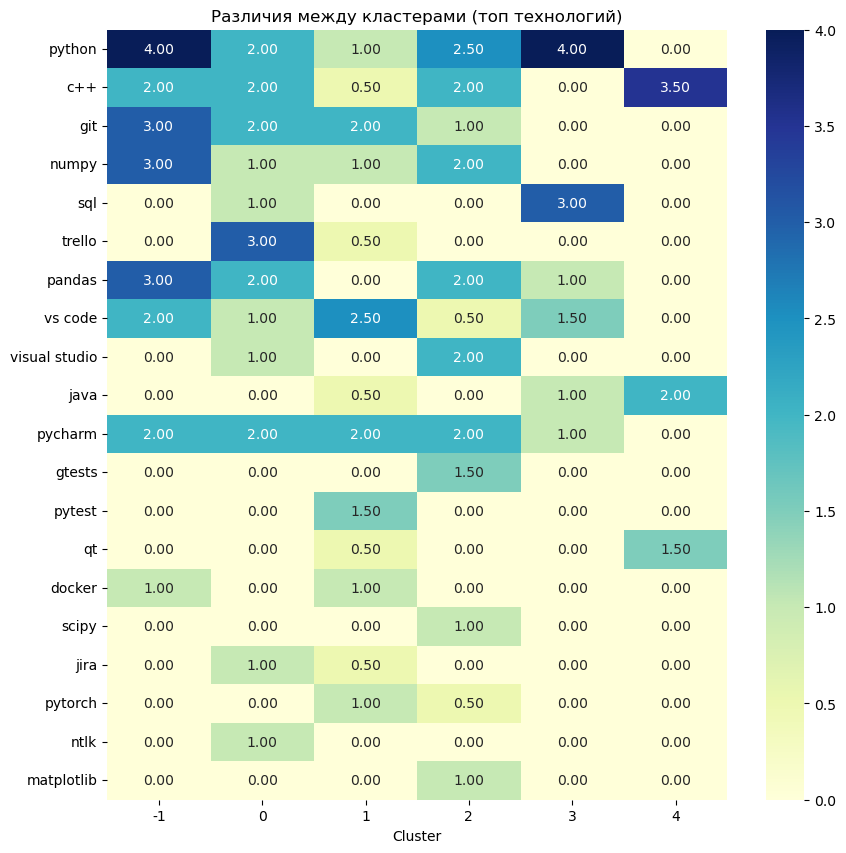

In [199]:
draw_heat_map(da_de_anomalies, da_de_anomalies.columns, cluster_labels, 20)


**Вывод по DA/DS**: Python + numpy + pandas + pytorch + scipy + matplotlib (2 anom cluster),
nltk, (c++, docker, java). 

# Frontend developer

In [ ]:
# Выборка строк, в которых 'frontend developer' присутствует в списке ролей
frontend_df = result_df[result_df['roles'].str.contains('frontend developer')]

# print(frontend_df['git'])

In [201]:
dev_tech = list(set(dev_tools)&set(frontend_df.columns))
print(dev_tech)
frontend_df = frontend_df.drop(dev_tech, axis=1)
frontend_df = frontend_df.drop(tech_columns, axis=1)
frontend_df = frontend_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
frontend_df = frontend_df.drop(role_columns, axis=1)

# frontend_df = frontend_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'trello', 'jira', 'docker', 'pandas', 'slack', 'notion'], axis=1) 

['intelijiidea', 'make', 'sublime text', 'conda', 'poetry', 'gitlab', 'collab', 'vsc', 'visual studio', 'mssql server', 'jetbrains', 'git', 'jupiter notebook', 'postman', 'unity', 'xcode', 'idea', 'intelijidea', 'clion', 'visual stusio', 'nodejs', 'brackets', 'sourcetree', 'webstrom', 'vs code', 'anaconda', 'pycharm', 'spyder', 'react devtools', 'intellij', 'colab', 'bash', 'ms server', 'atom', 'qt creator', 'filezilla', 'intellijidea', 'google colaboratory', 'jupiter', 'eclipse', 'visual studio code', 'netbeans ide', 'androidstudio', 'godot', 'jupyter-notebook', 'jupyter', 'datagrip', 'postgresql', 'unreal engine', 'redis', 'sublime', 'rstudio', 'phpstorm', 'cmake', 'webstorm', 'notepad++', 'intelij idea', 'kuka workvisual', 'kibana', 'ms visual studio', 'matlab', 'vmwareworkstation', 'intellj idea', 'jupyter notebook', 'googlecolab', 'pucharm', 'github', 'bitbucket', 'qtcreator', 'code', 'got', 'visualstudio', 'wsl', 'sublimetext', 'maven', 'vs', 'google colab', 'wakatime', 'rider', 

In [202]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = frontend_df.columns[frontend_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

frontend_df = frontend_df.drop(zero_columns, axis=1)

data_frontend = frontend_df.values

Колонки с нулевыми значениями: ['wsgiref', 'gitactions', 'rspec', 'spring security', 'yii', 'evernote', 'beautifulsoup', 'nemo', 'razdel', 'gotest', 'swiftui', 'arduino c', 'xgboost', 'twint', 'snakemake', 'ms teams', 'quill', 'travis cl', 'pymongo', 'coroutines', 'github projects', 'custom view', 'gitlab projects', 'pillow', 'nextjs', 'j', 'lxml', 'archimate', 'stl', 'matematica', 'phython', 'myplotlib', 'cd', 'aiohttp', 'pyplot', 'aris', 'mockito', 'fast api', 'podman', 'openshift', 'vulkan', 'sklearn', 'basecamp', 'clickup', 'pivotaltracker', 'todoist', 'glfw', 'yaml-cpp', 'gorilla mux', 'mokito', 'winapi', 'ef core', 'lightfm', 'yandex tank', 'bomardier', 'pyav', 'mediapipe', 'spring jdbc', 'tf', 'psutil', 'rails', 'polyfactory', 'confluence', 'notification', 'apispec', 'unittest', '.', 'tortoise', 'microsoft todo', 'sdml', 'play', 'capybara', 'xamarin.forms', 'android jetpack', 'pydantic', 'multiprocessing', 'typing', 'itertools', 'zenject', 'loguru', '.net framework', 'zoom', 'gt

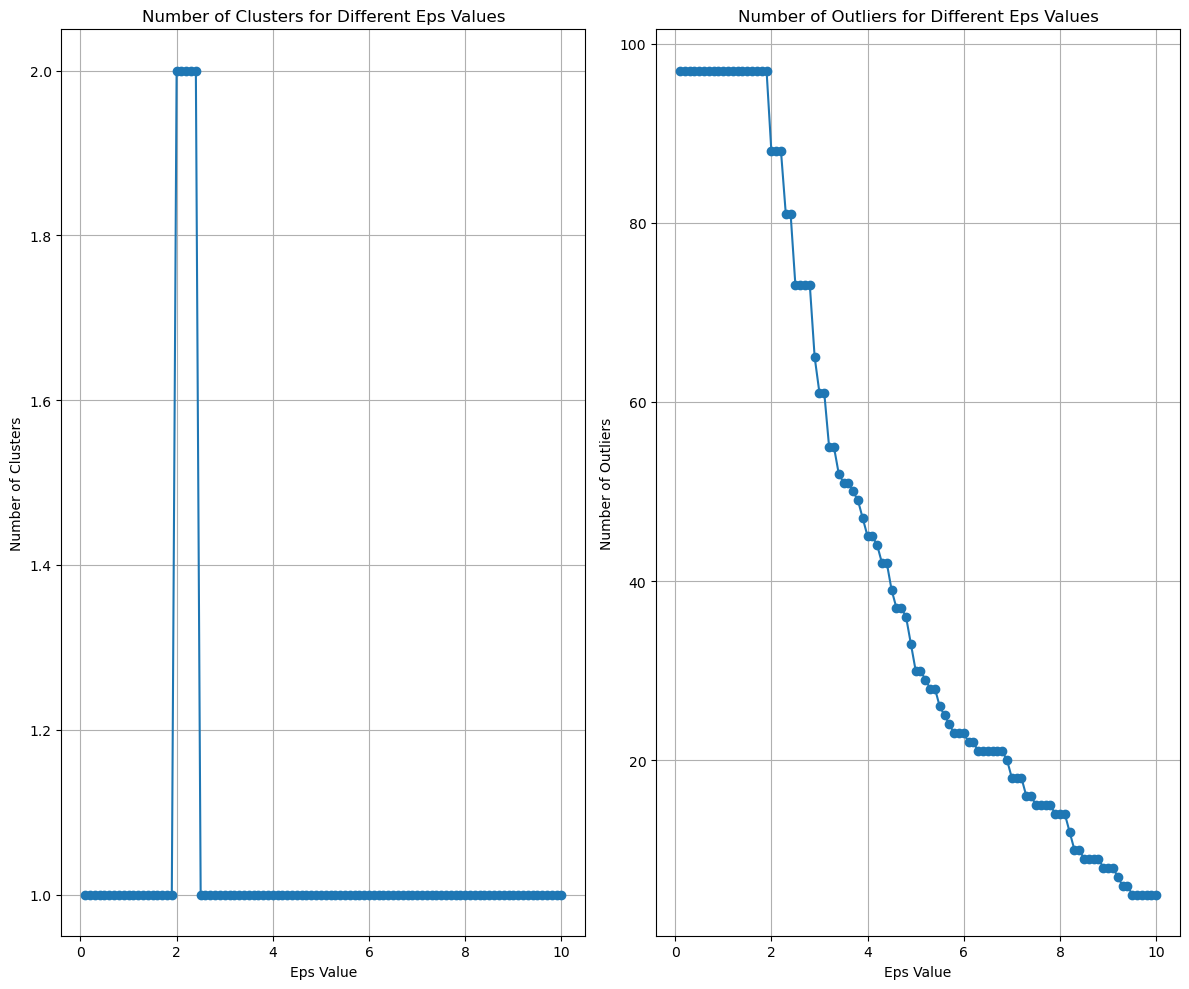

In [203]:
find_parameters_for_DBSCUN(0.1, 10.0, 100, data_frontend)

In [204]:
dbscan = DBSCAN(eps=2.2, min_samples=5)
dbscan.fit(data_frontend)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


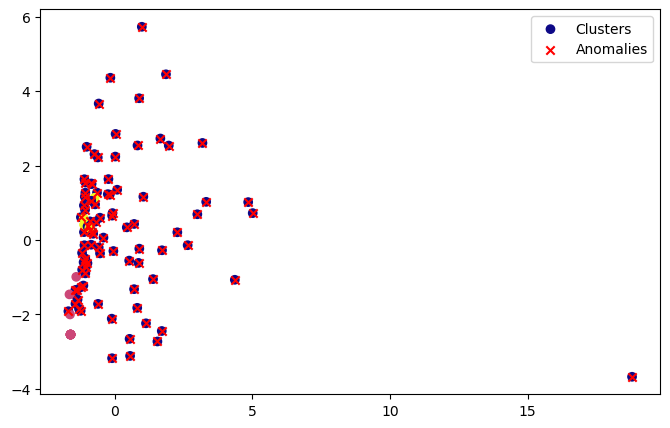

In [205]:
draw_clusters(data_frontend, cluster_labels, is_anomaly)

In [206]:
analyze_clusters(data_frontend, cluster_labels, frontend_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['telegram', 'javascript', 'react', 'java spring', 'redux'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['linq', 'redux', 'numpy', 'python', 'c++'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['haskell', 'java', 'numpy', 'python', 'c++'], dtype='object')



In [207]:
count_points_in_clusters(cluster_labels)

Кластер 0: 12 точек
Кластер 1: 5 точек
Кластер -1: 88 точек


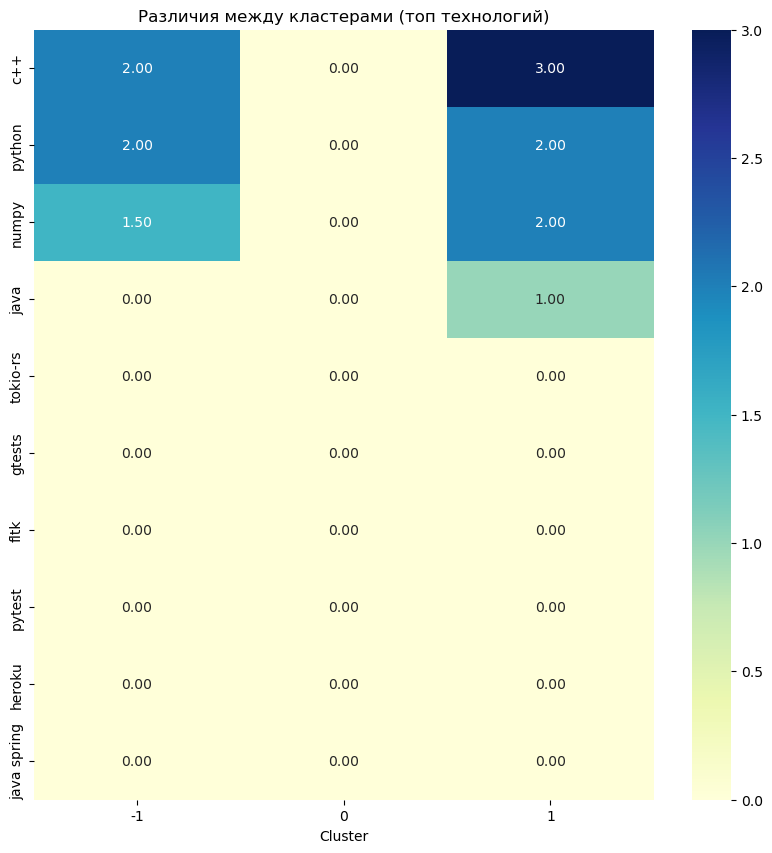

In [208]:
draw_heat_map(data_frontend, frontend_df.columns, cluster_labels)

Общие знания: Python + Numpy, C++; специфичные: java; 'javascript', 'react', 'java spring', 'redux'

## frontend anomalies

In [209]:
frontend_anomalies = frontend_df[is_anomaly]
frontend_anomalies.head()

,tokio-rs,lua,c++,mindmeister,ruby on rails,puppeteer,opencv,koa,php,google test,...,swift ui,reason ml,ruby,notion,jetbrains teamcity,python,spring,cg,next.js,redux
2,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,2,3,3,0,0,0
26,0,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
27,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
29,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


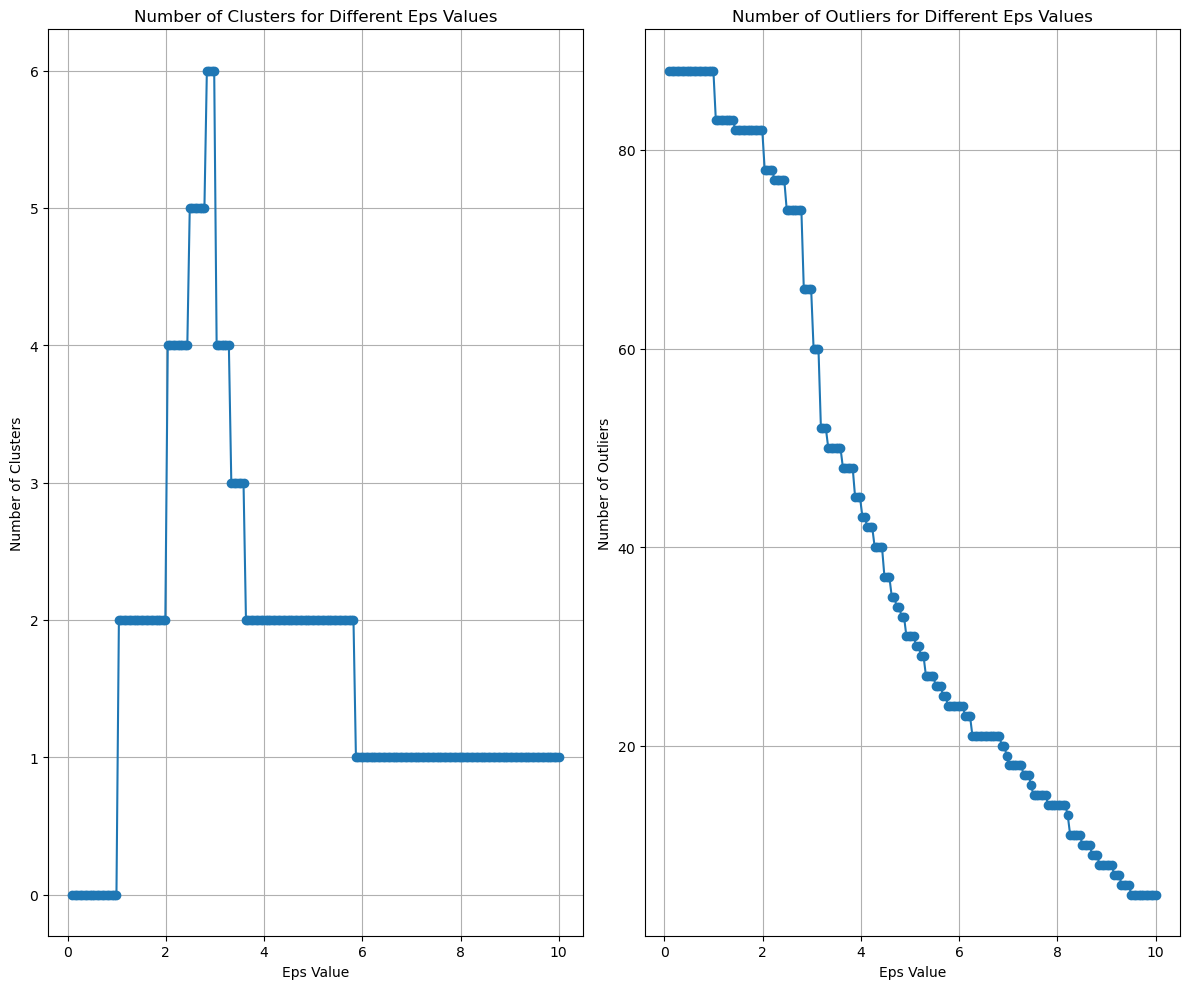

In [210]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, frontend_anomalies, 2)

In [211]:
dbscan = DBSCAN(eps=2.9, min_samples=2)
dbscan.fit(frontend_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 6


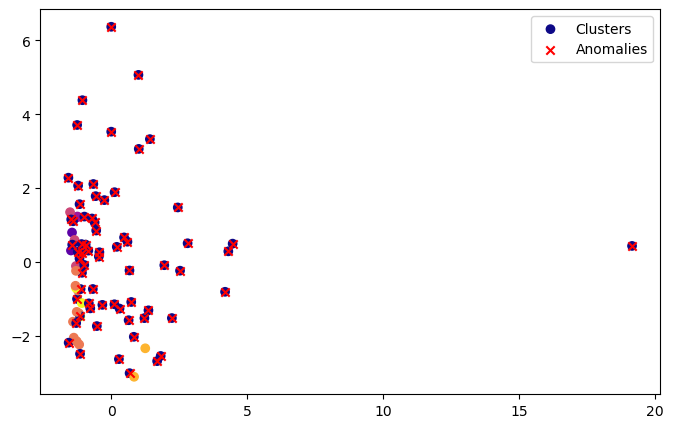

In [212]:
draw_clusters(frontend_anomalies, cluster_labels, is_anomaly)

In [213]:
analyze_clusters(frontend_anomalies, cluster_labels, frontend_anomalies.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['telegram', 'javascript', 'react', 'java spring', 'redux'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['pandas', 'sfml', 'numpy', 'python', 'c++'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['c#', 'bootstrap', 'c++', 'numpy', 'python'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['matplotlib', 'numpy', 'scipy', 'python', 'c++'], dtype='object')

Кластер 3:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['clojure', 'c#', 'java', 'python', 'c++'], dtype='object')

Кластер 4:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['linq', 'redux', 'python', 'typescript', 'javascript'], dtype='object')

Кластер 5:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['java', 'tkinter', 'c++', 'rust', 'python'], dtype='object')



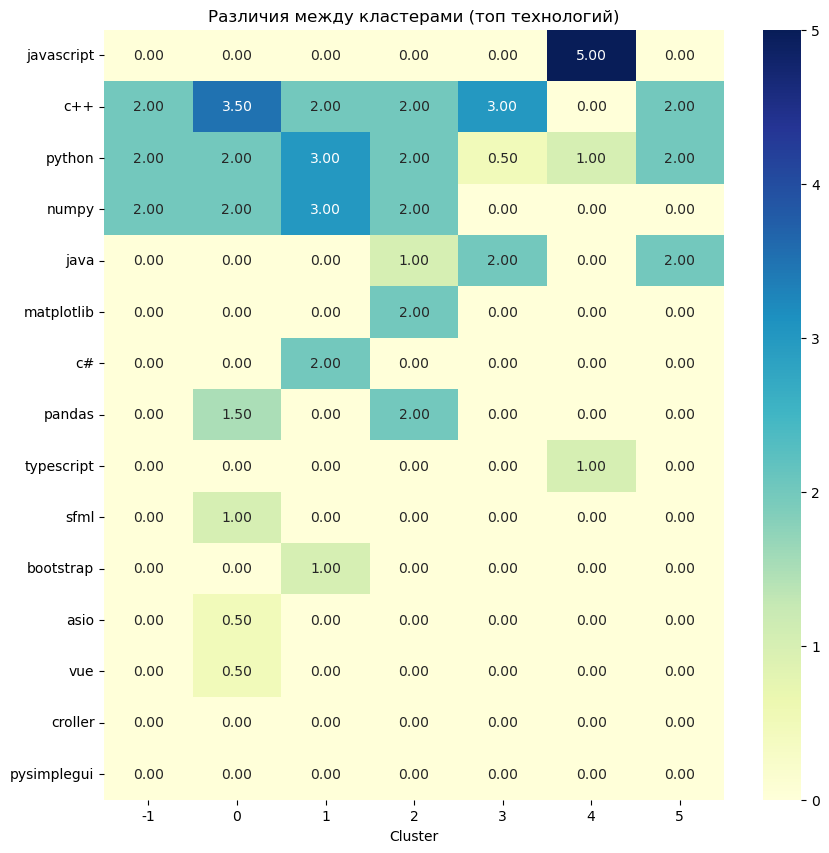

In [214]:
draw_heat_map(frontend_anomalies, frontend_anomalies.columns, cluster_labels, 15)

In [215]:
count_points_in_clusters(cluster_labels)

Кластер 0: 2 точек
Кластер 1: 2 точек
Кластер 2: 3 точек
Кластер 3: 10 точек
Кластер 4: 2 точек
Кластер 5: 3 точек
Кластер -1: 66 точек


**Вывод по фронтенду:** характерные технологии JS/TypeScript, React/VueJS,  Java,
python; 'javascript', 'react', 'java spring', 'redux'

# UI/UX 

In [216]:
ui_ux_df = result_df[result_df['roles'].str.contains('ux/ui')]

ui_ux_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
12,ST110277,2,1,1,2,1,1,1,5,5,...,0,0,0,0,0,0,0,0,0,0
13,ST089430,C++ - 2\nPython - 2\nJava - 1,Numpy - 2,,VS Code - 2\nPyCharm - 2\nGit - 1,,,,3,5,...,0,0,0,0,0,0,0,0,0,0
34,ST086871,C++ 2\nPython 3\nC# 2,nan,nan,VS Code 1\nVS Community 2\nPyCharm 2\nGit 1,nan,nan,nan,3,5,...,0,0,0,0,0,0,0,0,0,0
38,ST095277,С++ - 2\nС# - 4\nPython - 1\nJava - 1\nHaskell...,.NET - 2,nan,GitHub - 3\nVisualStudio - 3,nan,nan,nan,1,5,...,0,0,0,0,0,0,0,0,0,0
45,ST097831,Python - 3\nR - 2\nJavaScript - 2\nС# - 1,Numpy - 3\nPandas - 3,nan,VS Code - 3\nGit - 3,pytest - 3,Docker - 2,Trello - 5\nJira - 2,3,5,...,0,0,0,0,0,0,0,0,0,0


In [217]:
ui_ux_df = ui_ux_df.drop(tech_columns, axis=1)
ui_ux_df = ui_ux_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
ui_ux_df = ui_ux_df.drop(role_columns, axis=1)
# ui_ux_df = ui_ux_df.drop(['python', 'c++', 'git', 'numpy', 'pycharm'], axis=1)
ui_ux_df = ui_ux_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'trello', 'jira', 'docker', 'pandas', 'slack', 'notion'], axis=1) 

In [218]:
ui_ux_df = drop_zero_columns(ui_ux_df)
data_ui_ux = ui_ux_df.values

Колонки с нулевыми значениями: ['wsgiref', 'gitactions', 'tokio-rs', 'rspec', 'make', 'spring security', 'yii', 'poetry', 'collab', 'google test', 'evernote', 'solidity', 'beautifulsoup', 'nemo', 'razdel', 'gotest', 'ncurses', 'arduino c', 'ember', 'xgboost', 'twint', 'snakemake', 'ms teams', 'quill', 'ms server', 'qt creator', 'travis cl', 'jupiter', 'pymongo', 'godot', 'torch', 'coroutines', 'phpstorm', 'github projects', 'custom view', 'monday.com', 'gitlab projects', 'pillow', 'ntlk', 'nextjs', 'j', 'lxml', 'archimate', 'stl', 'phython', 'npm', 'rxjs', 'myplotlib', 'cd', 'aiohttp', 'bitbucket', 'aris', 'mockito', 'fast api', 'podman', 'openshift', 'clap-rs', 'vulkan', 'sklearn', 'basecamp', 'clickup', 'pivotaltracker', 'todoist', 'glfw', 'yaml-cpp', 'factor', 'svn', 'wireframe', 'gorilla mux', 'mokito', 'winapi', 'ef core', 'lightfm', 'yandex tank', 'bomardier', 'sublime text', 'pyav', 'mediapipe', 'spring jdbc', 'tf', 'psutil', 'rails', 'polyfactory', 'confluence', 'notification',

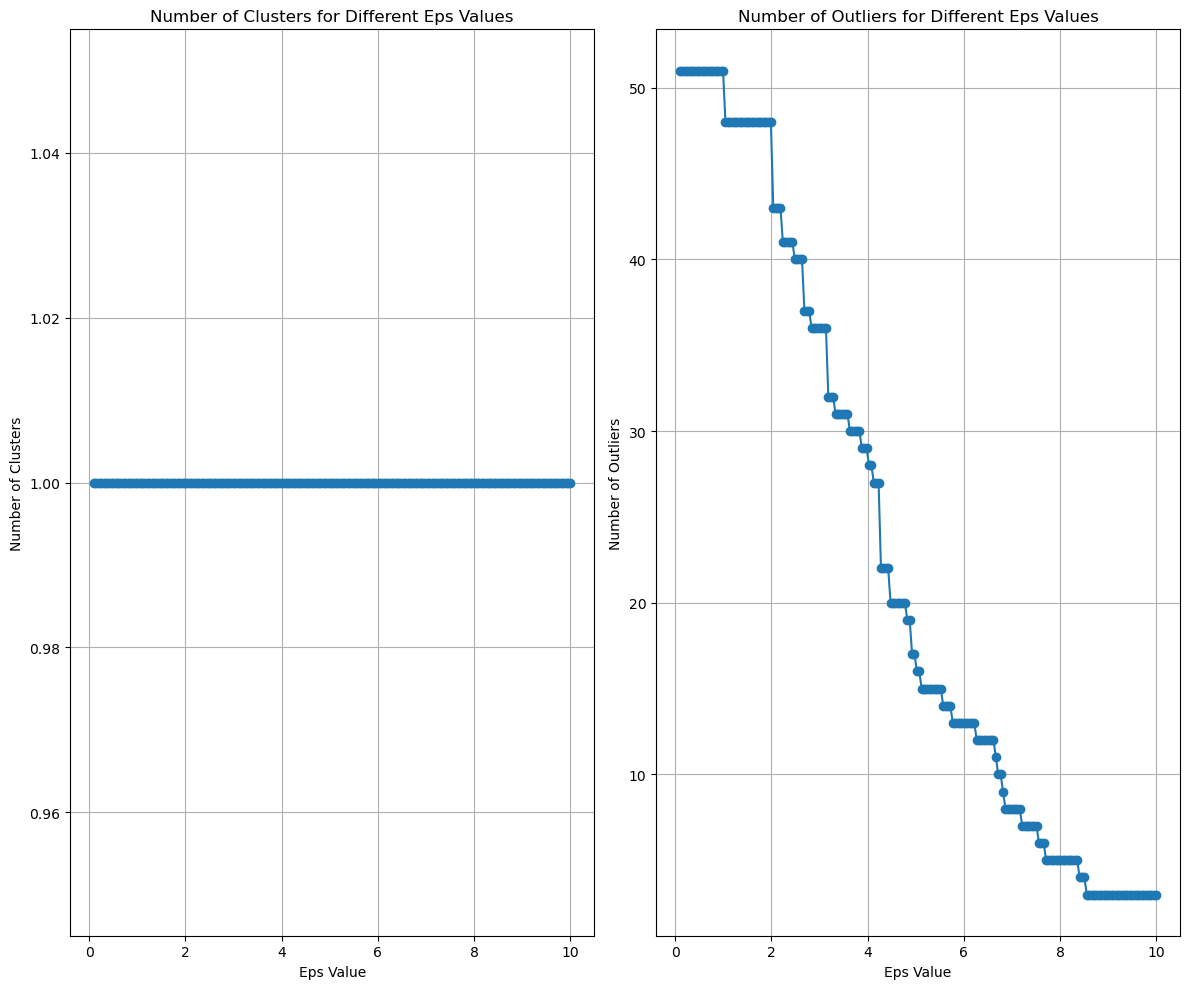

In [219]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_ui_ux)

In [220]:
dbscan = DBSCAN(eps=4.1, min_samples=5)
dbscan.fit(data_ui_ux)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 1


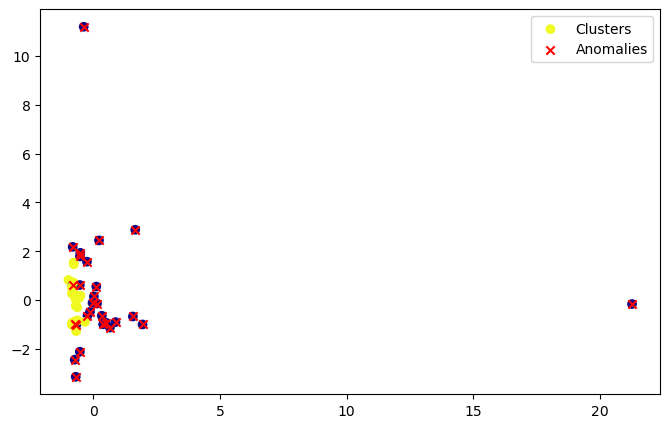

In [221]:
draw_clusters(data_ui_ux, cluster_labels, is_anomaly)

In [222]:
analyze_clusters(data_ui_ux, cluster_labels,  ui_ux_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['mobx', 'c#', 'renpy', 'telegram', 'redux'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['java', 'anaconda jupyter notebook', 'vs', 'c#', 'matlab'], dtype='object')



In [223]:
count_points_in_clusters(cluster_labels)

Кластер 0: 30 точек
Кластер -1: 28 точек


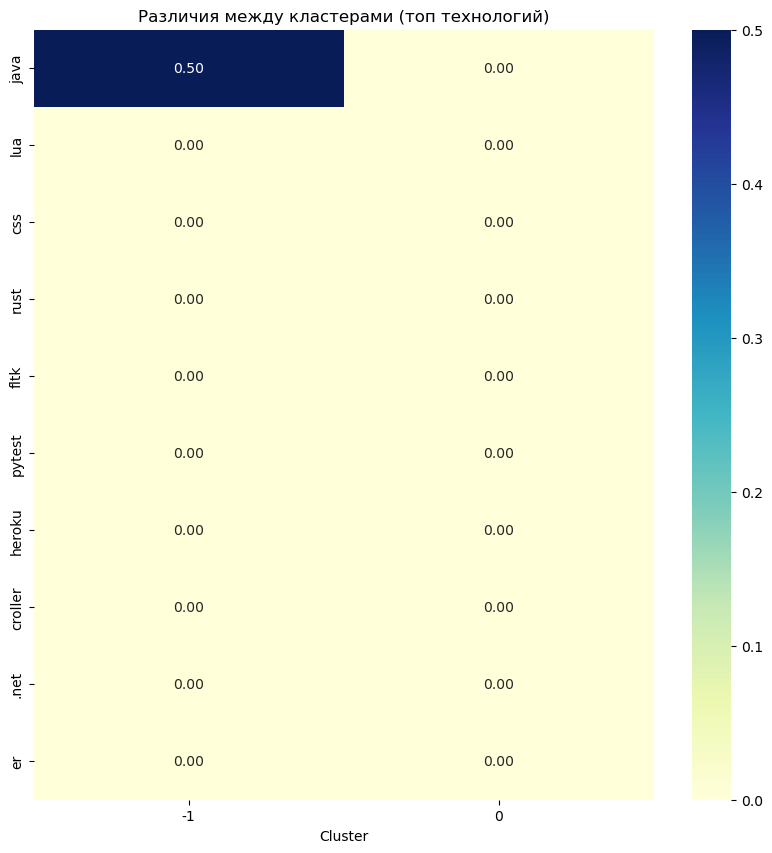

In [224]:
draw_heat_map(data_ui_ux, ui_ux_df.columns, cluster_labels)  # сделать перегрузку функций?

**Вывод по ui/ux**: 'mobx', 'renpy', 'redux', java, c#, matlab

### UI/UX anomalies

In [225]:
ui_ux_anomalies = ui_ux_df[is_anomaly]
ui_ux_anomalies.head()

,lua,mindmeister,ruby on rails,puppeteer,opencv,koa,php,d,jenkins,rollup,...,seaborn,erlang,cobol,swift ui,vs,reason ml,ruby,qt,cg,redux
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
86,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,3,0,0


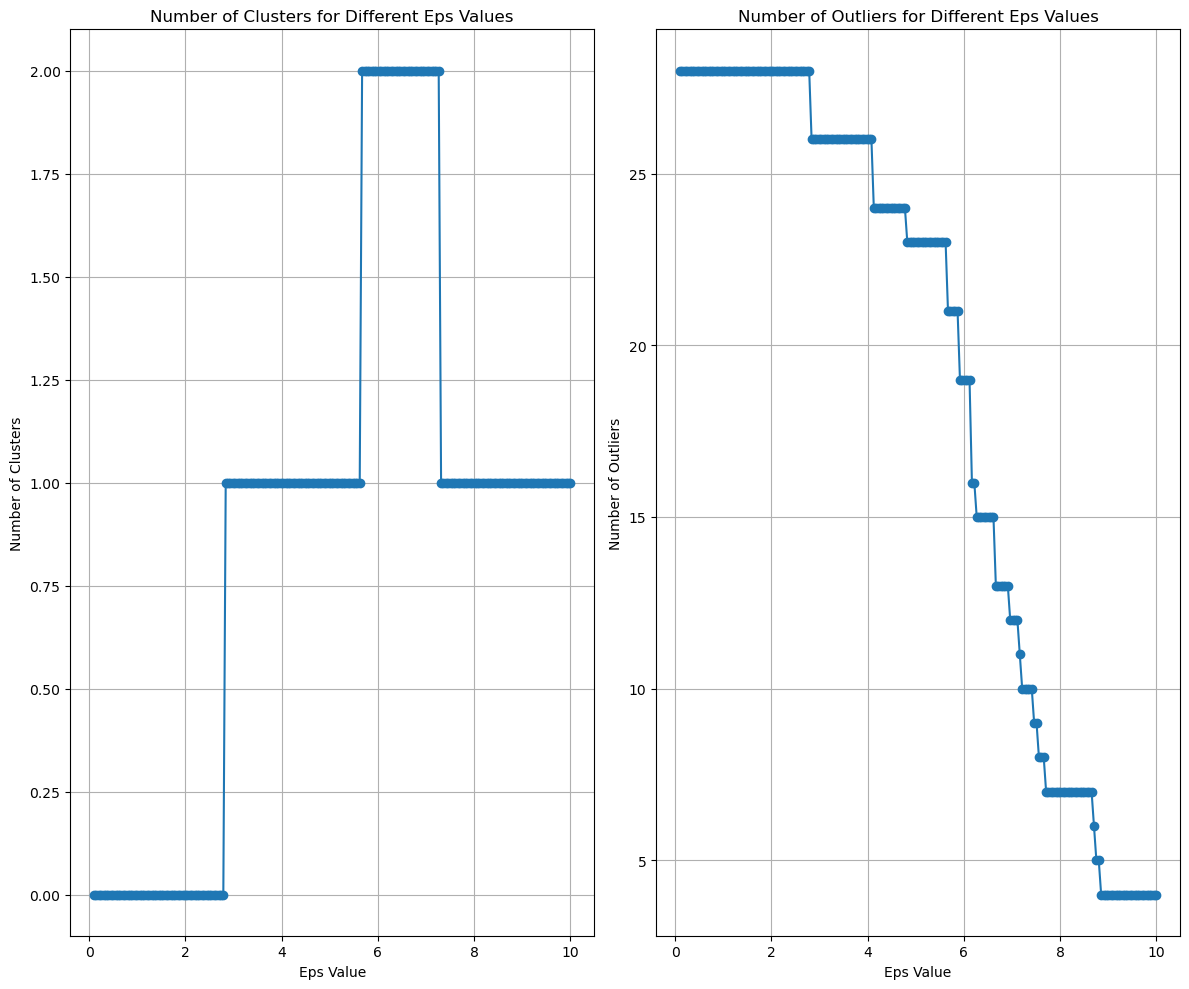

In [226]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, ui_ux_anomalies, 2)

In [227]:
dbscan = DBSCAN(eps=6.1, min_samples=2)
dbscan.fit(ui_ux_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


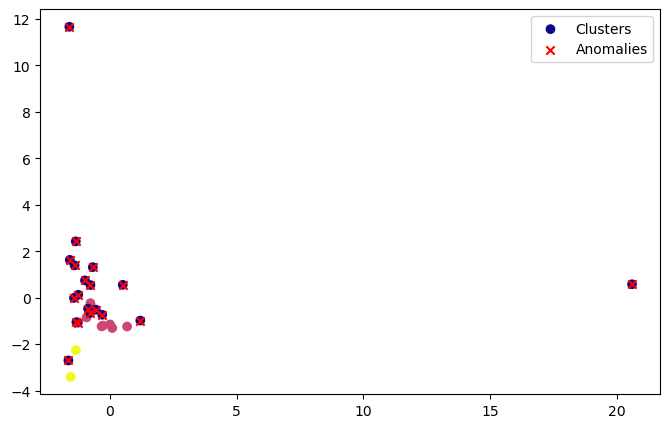

In [228]:
draw_clusters(ui_ux_anomalies, cluster_labels, is_anomaly)

In [229]:
count_points_in_clusters(cluster_labels)

Кластер 0: 7 точек
Кластер 1: 2 точек
Кластер -1: 19 точек


In [230]:
analyze_clusters(ui_ux_anomalies, cluster_labels,  ui_ux_anomalies.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['javascript', 'react', 'c#', 'mobx', 'redux'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['bumpy', 'java', 'redux', 'react', 'javascript'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['qt', 'cocoa touch', 'objective-c', 'swift', 'xcode'], dtype='object')



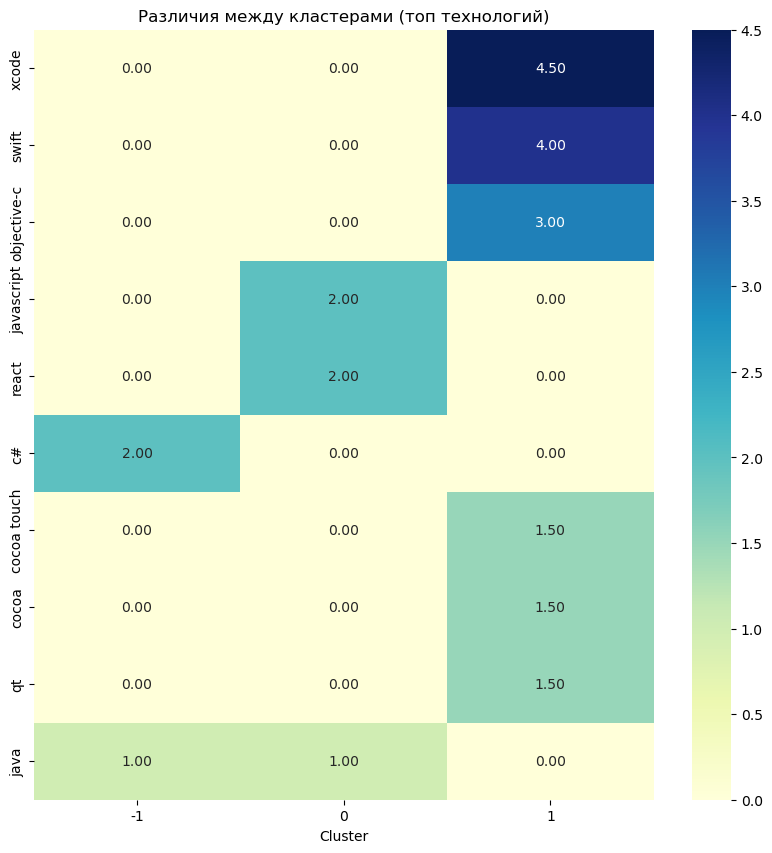

In [231]:
draw_heat_map(ui_ux_anomalies, ui_ux_anomalies.columns, cluster_labels, 10)

Вывод по UI/UX: 
* java, c#, 
* java, JS, React, mobx, redux
* Xcode, swift, objective-c, cocoa, cocoa touch?
* c++ + qt


# PM

In [232]:
pm_df = result_df[result_df['roles'].str.contains('pm')]
pm_df = pm_df[pm_techs]
pm_df.head()

,microsoft todo,azure devops server,yandextracker,ms project,miro,mindmeister,youtrack,slack,jetbrains teamcity,azure devops,...,unity,gitlab,jira,basecamp,todoist,github projects,notion,bitbucket,clickup,evernote
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [233]:
# pm_df = pm_df.drop(tech_columns, axis=1) 
# pm_df = pm_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# pm_df = pm_df.drop(role_columns, axis=1)

# sa_ba_df = sa_ba_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'docker', 'pandas'], axis=1) 

In [234]:
# Проверяем, какие колонки полностью состоят из нулевых значений
zero_columns = pm_df.columns[pm_df.eq(0).all(axis=0)]

print("Колонки с нулевыми значениями:", zero_columns.tolist())

pm_df = pm_df.drop(zero_columns, axis=1)

data_pm = pm_df.values

Колонки с нулевыми значениями: ['microsoft todo', 'azure devops server', 'yandextracker', 'youtrack', 'slack', 'jetbrains teamcity', 'azure devops', 'ms teams', 'pivotaltracker', 'evernote']


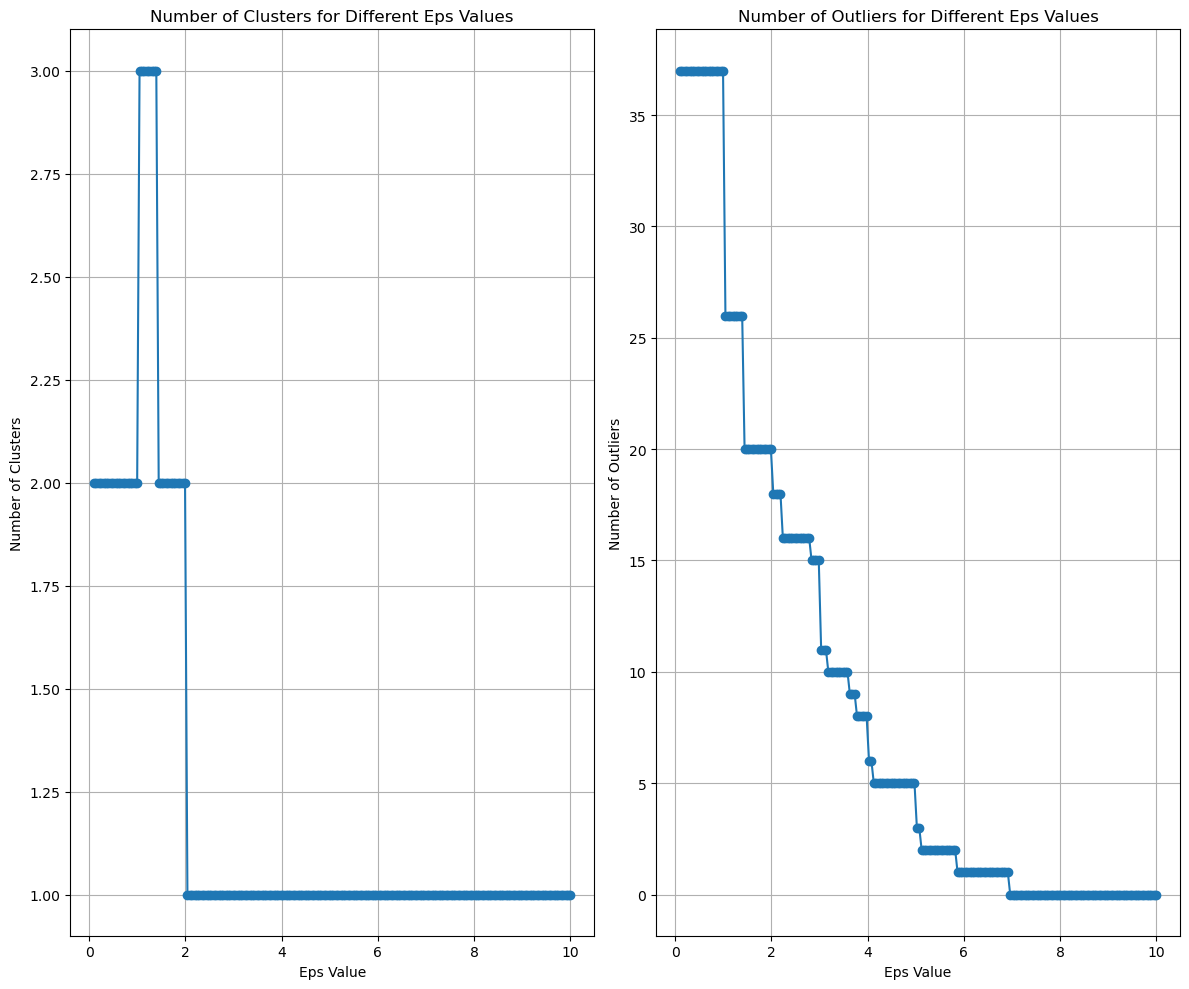

In [235]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_pm)

In [236]:
dbscan = DBSCAN(eps=1, min_samples=5)
dbscan.fit(data_pm)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


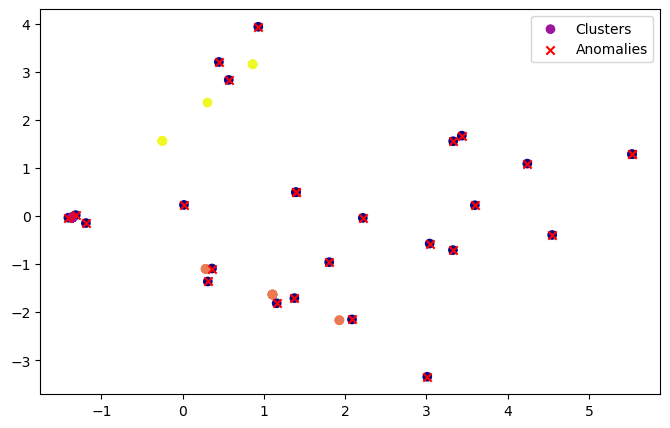

In [237]:
draw_clusters(data_pm, cluster_labels, is_anomaly)

In [238]:
count_points_in_clusters(cluster_labels)

Кластер 0: 45 точек
Кластер 1: 10 точек
Кластер 2: 6 точек
Кластер -1: 26 точек


In [239]:
analyze_clusters(data_pm, cluster_labels, pm_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['miro', 'clickup', 'jira', 'telegram', 'trello'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['monday.com', 'mindmeister', 'miro', 'github', 'clickup'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['mindmeister', 'miro', 'github', 'clickup', 'trello'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['mindmeister', 'miro', 'github', 'clickup', 'jira'], dtype='object')



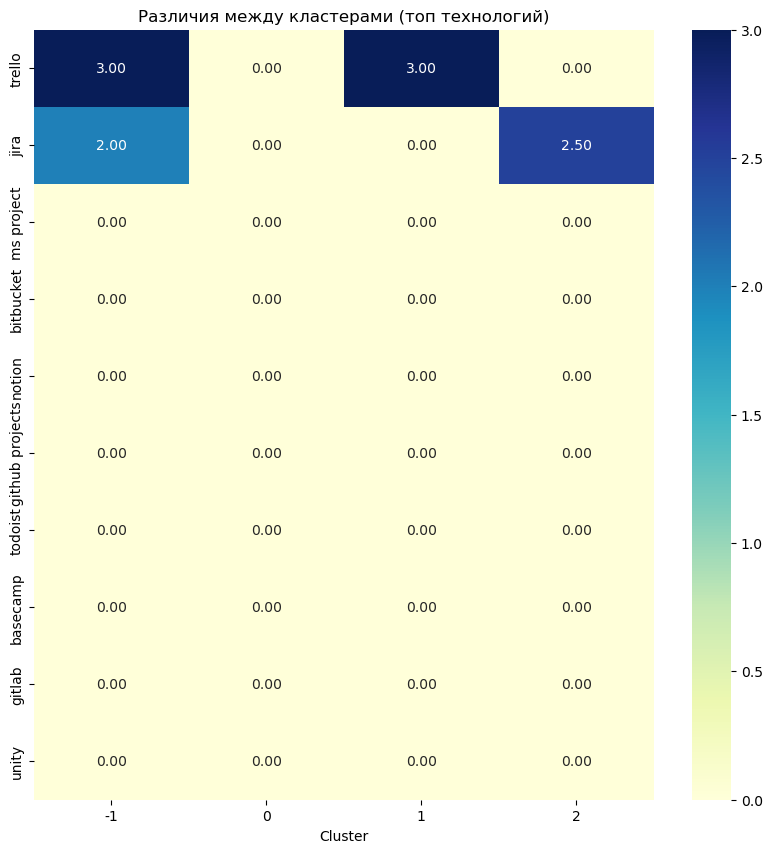

In [240]:
draw_heat_map(data_pm, pm_df.columns, cluster_labels) 

Trello, jira, clickup, mindmeister

## PM anomalies

In [241]:
pm_anomalies = pm_df[is_anomaly]
pm_anomalies.head()

,ms project,miro,mindmeister,monday.com,telegram,gitlab projects,confluence,zoom,asana,github,...,trello,unity,gitlab,jira,basecamp,todoist,github projects,notion,bitbucket,clickup
32,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,4,0,0
62,0,0,0,0,0,0,0,0,0,0,...,3,0,2,1,0,0,0,0,3,0
66,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,0,0,0,0,0
70,0,3,0,0,0,0,0,3,0,0,...,0,0,0,3,0,0,0,4,0,0


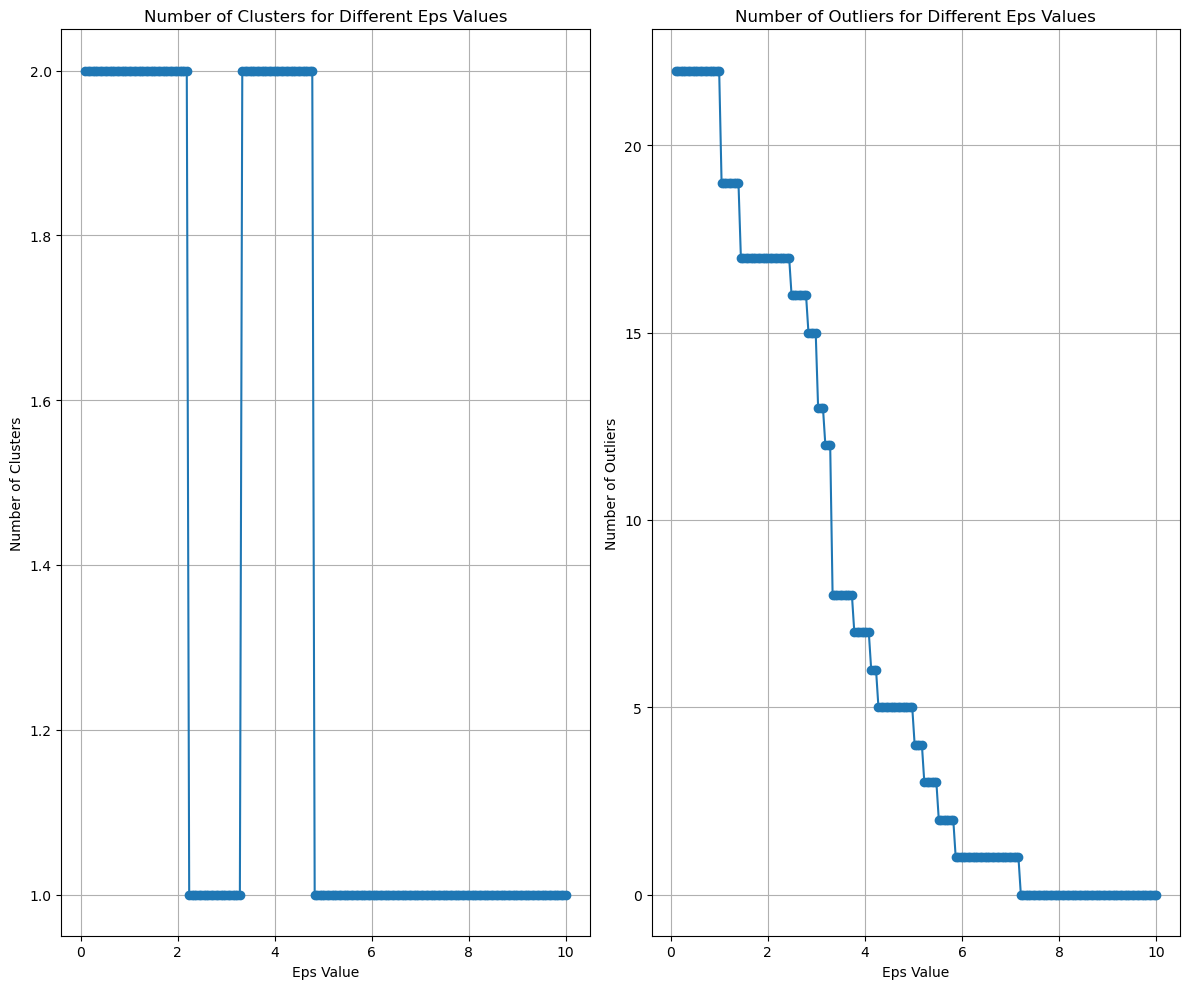

In [242]:
find_parameters_for_DBSCUN(0.1, 10.0, 200,  pm_anomalies, 2)

In [243]:
dbscan = DBSCAN(eps=4.5, min_samples=2)
dbscan.fit(pm_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


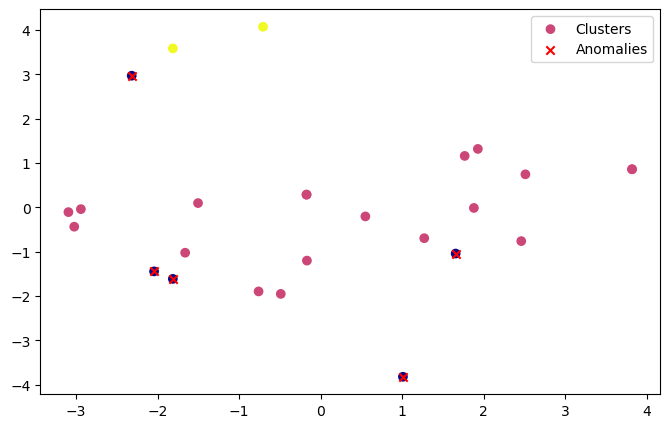

In [244]:
draw_clusters(pm_anomalies, cluster_labels, is_anomaly)

In [245]:
count_points_in_clusters(cluster_labels)

Кластер 0: 19 точек
Кластер 1: 2 точек
Кластер -1: 5 точек


In [246]:
analyze_clusters(pm_anomalies, cluster_labels, pm_anomalies.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['gitlab projects', 'miro', 'clickup', 'telegram', 'trello'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['coggle', 'gitlab', 'notion', 'trello', 'jira'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['github', 'clickup', 'miro', 'confluence', 'jira'], dtype='object')



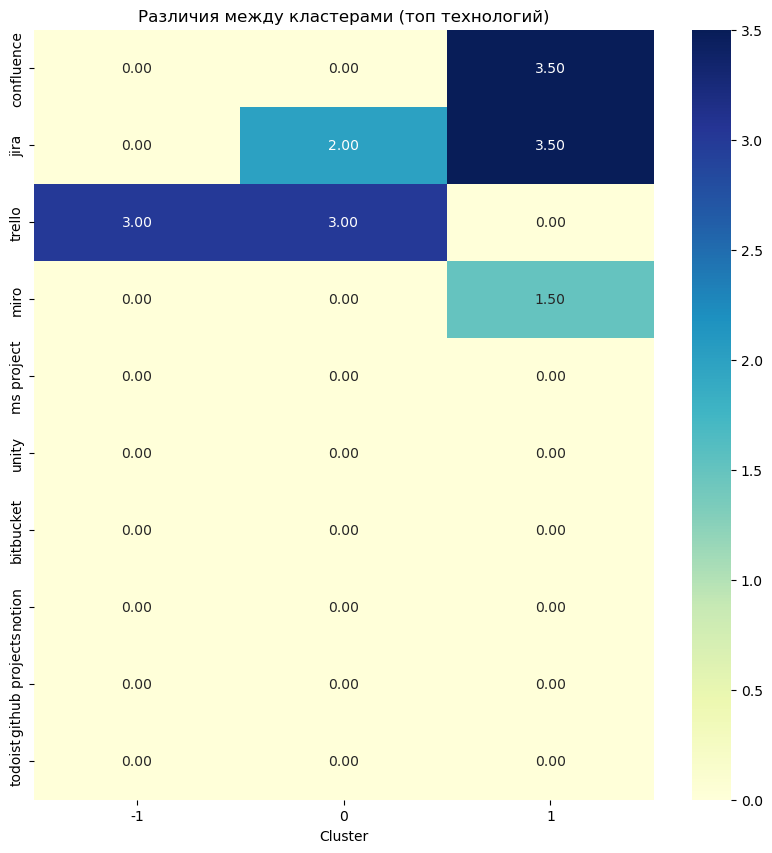

In [247]:
draw_heat_map(pm_anomalies, pm_anomalies.columns, cluster_labels)

Вывод: популярны trello, jira, confluence, miro, coggle

# Implementation

In [248]:
imp_df = result_df[result_df['roles'].str.contains('implementation')]
imp_df = imp_df[imp_techs]
imp_df.head()


,cd,decker,iis manager,cl,docker-compose,gitactions,docker,aws cloudformation,gitlab-ci,maven,...,gitlab,microsoft azure,podman,openshift,github actions,kubernetes,s,cicleci,travis cl,teamcity
5,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
# imp_df = imp_df.drop(tech_columns, axis=1) 
# imp_df = imp_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# imp_df = imp_df.drop(role_columns, axis=1)

In [250]:
imp_df = drop_zero_columns(imp_df)
data_imp = imp_df.values

Колонки с нулевыми значениями: ['decker', 'iis manager', 'cl', 'docker-compose', 'gitactions', 'gitlab-ci', 'maven', 'gradle', 'gitlab ci', 'gitlab', 'microsoft azure', 'podman', 'openshift', 's', 'cicleci', 'travis cl', 'teamcity']


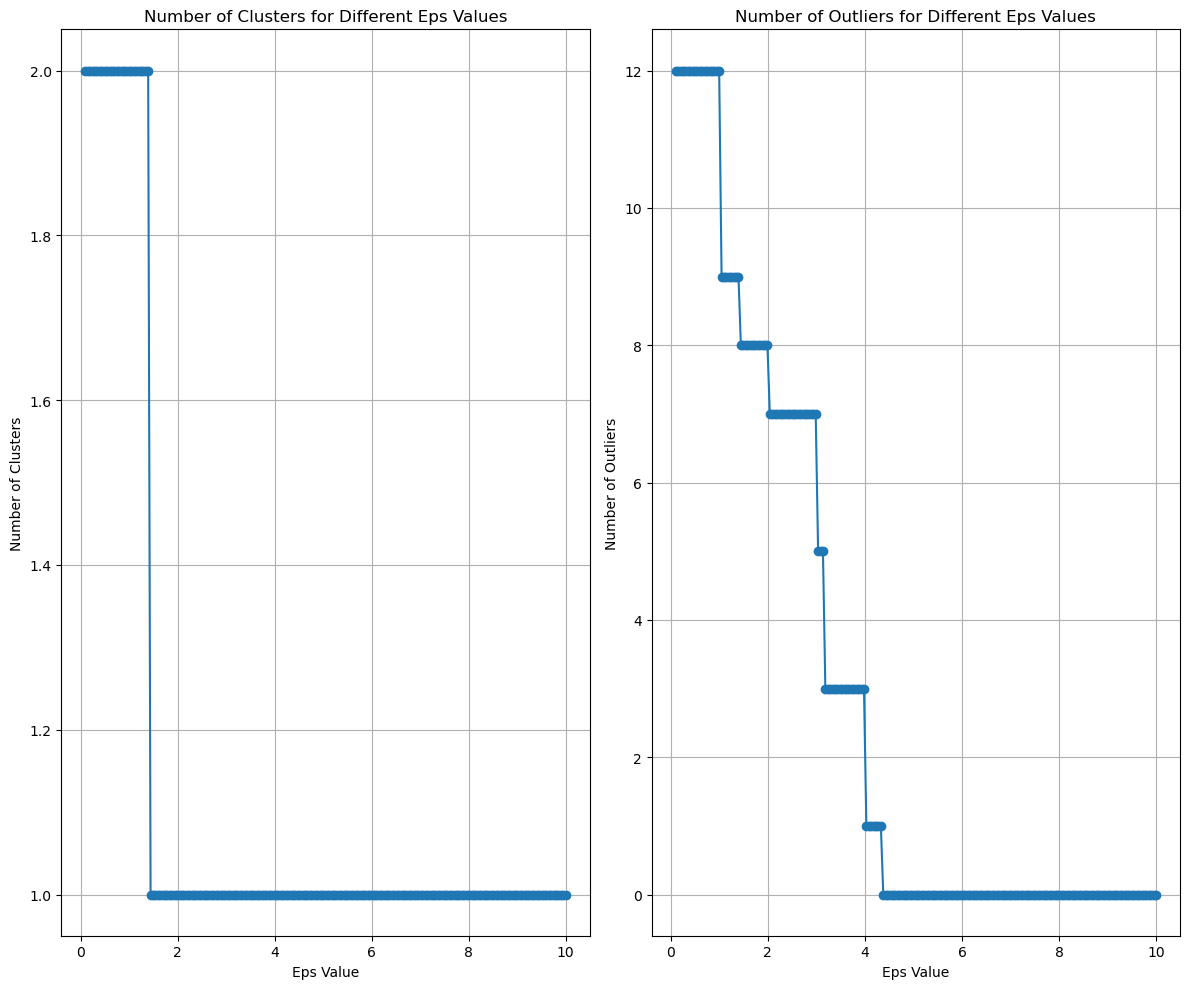

In [251]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_imp)

In [252]:
dbscan = DBSCAN(eps=1.3, min_samples=5)
dbscan.fit(data_imp)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


In [253]:
count_points_in_clusters(cluster_labels)

Кластер 0: 9 точек
Кластер 1: 17 точек
Кластер -1: 9 точек


In [254]:
analyze_clusters(data_imp, cluster_labels, imp_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['gitea', 'docker', 'jenkins', 'gitlabci', 'github actions'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['gitea', 'gitlabci', 'github actions', 'kubernetes', 'docker'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['travis ci', 'gitea', 'gitlabci', 'github actions', 'kubernetes'], dtype='object')



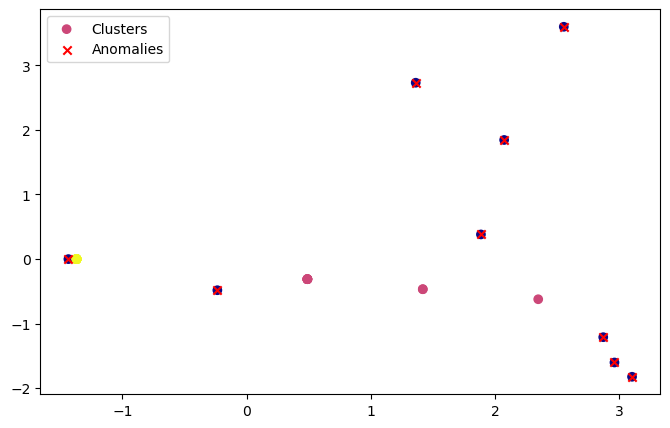

In [255]:
draw_clusters(data_imp, cluster_labels, is_anomaly)

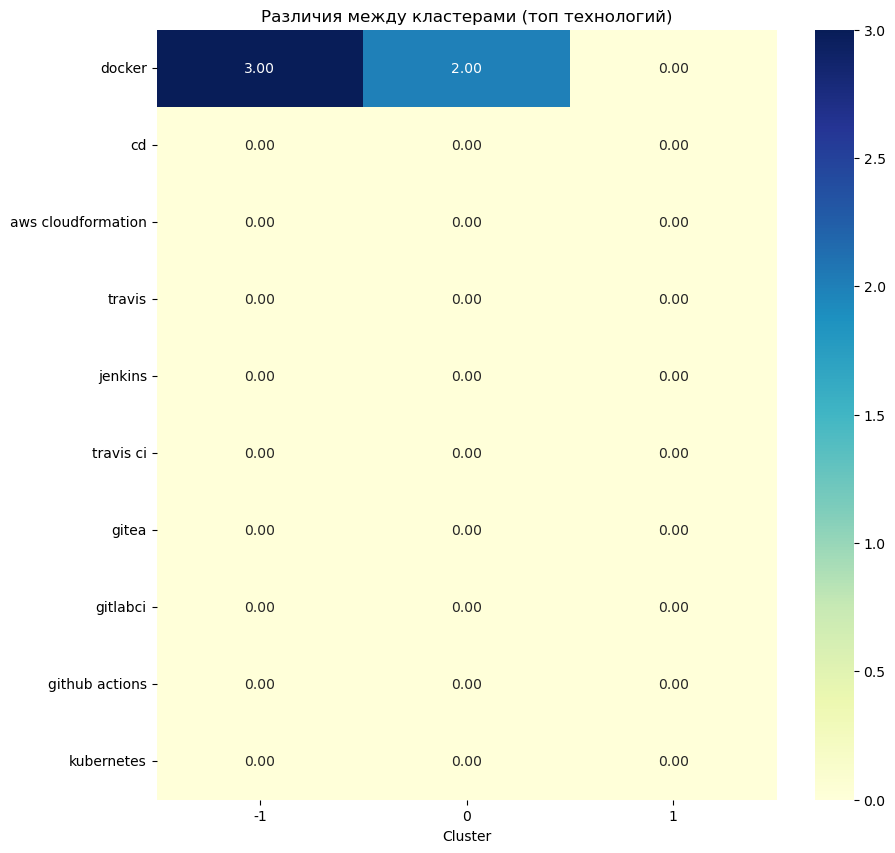

In [256]:
draw_heat_map(data_imp, imp_df.columns, cluster_labels) 

## Implementation anomalies

In [257]:
imp_anomalies = imp_df[is_anomaly]
imp_anomalies.head()

,cd,docker,aws cloudformation,travis,jenkins,travis ci,gitea,gitlabci,github actions,kubernetes
19,0,3,0,0,3,0,0,0,0,0
32,2,2,0,0,2,0,3,0,2,0
196,0,4,0,0,0,0,0,4,0,0
201,0,4,0,0,0,3,0,0,0,2
261,0,3,0,0,0,0,0,0,4,0


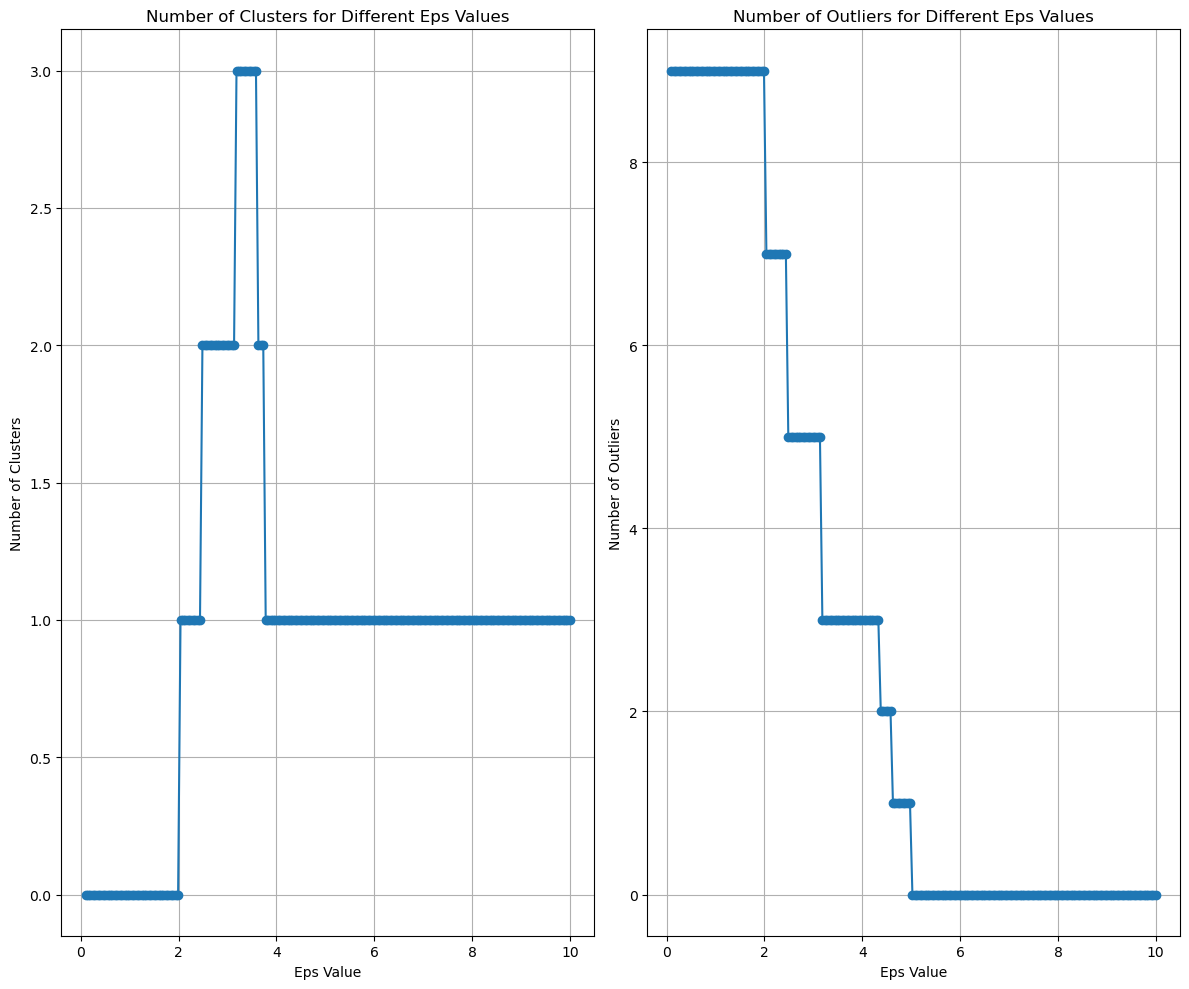

In [258]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, imp_anomalies, 2)

In [259]:
dbscan = DBSCAN(eps=3.6, min_samples=2)
dbscan.fit(imp_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


In [260]:
analyze_clusters(imp_anomalies, cluster_labels, imp_anomalies.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['jenkins', 'gitea', 'docker', 'gitlabci', 'github actions'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['github actions', 'kubernetes', 'docker', 'aws cloudformation',
       'jenkins'],
      dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['gitlabci', 'github actions', 'kubernetes', 'travis ci', 'docker'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['github actions', 'kubernetes', 'docker', 'travis ci', 'travis'], dtype='object')



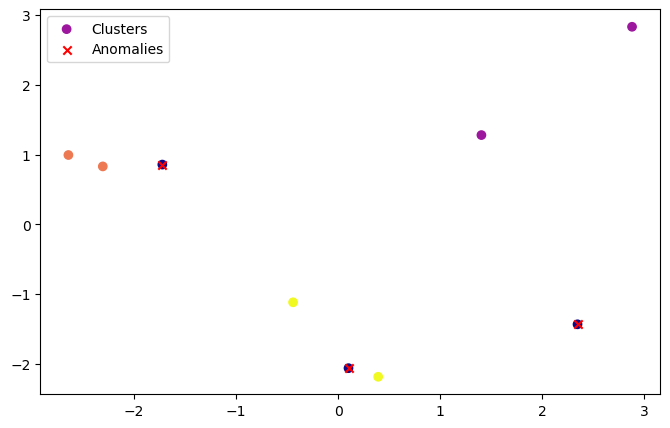

Кластер 0: 2 точек
Кластер 1: 2 точек
Кластер 2: 2 точек
Кластер -1: 3 точек


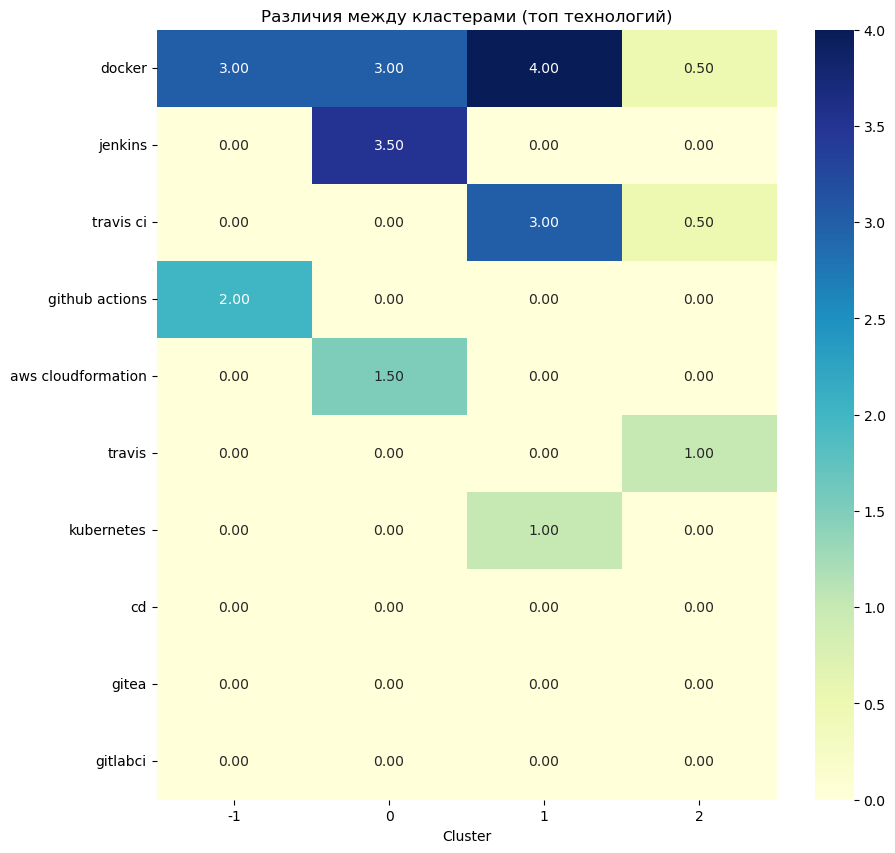

In [261]:
draw_clusters(imp_anomalies, cluster_labels, is_anomaly)
count_points_in_clusters(cluster_labels)
draw_heat_map(imp_anomalies, imp_anomalies.columns, cluster_labels, 20)

**Выводы по внедрению и развертыванию**: docker, github actions, jenkins, travis ci, kubernetes, gitea, aws cloudfornation  

# System or business analyst

In [262]:
sa_ba_df = result_df[result_df['roles'].str.contains('system or business analyst')]
sa_ba_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
11,ST112784,Python - 1,nan,nan,nan,nan,nan,nan,5,1,...,0,0,0,0,0,0,0,0,0,0
12,ST110277,2,1,1,2,1,1,1,5,5,...,0,0,0,0,0,0,0,0,0,0
24,ST068916,"c++, phython - 2","Numpy, Pandas - 2","BPMN, UML, power BI - 2","VS Code, PyCharm, Git - 2",,,"Jira, Trello - 3",5,1,...,0,0,0,0,0,0,0,0,0,0
32,ST115983,C++ - 4\nC# - 3\nAHK - 3\nJavaScript - 3\nJav...,React - 2\nVue - 3\nYii - 3\nLaravel - 3\nQt -...,UML - 3\nUML - 3,VS Code - 3\nPyCharm - 5\nGit - 4\nVS - 3\nVS ...,pytest - 3\nunittest - 3\nmutmut - 3\npytest -...,Jenkins - 2\nDocker - 3\nGitlab CI/CD - 2\nGit...,Jira - 1\nTrello - 1\n,5,3,...,0,0,0,0,0,0,0,0,0,0
36,ST095276,С++ - 2\nJava - 2\nPython - 3\nSQL - 2\n,Numpy - 3\nPandas - 4\nMatplotlib - 3\nSeaborn...,nan,VS Code - 4\nGit - 3,GTests - 2\n,Docker - 1\n,nan,5,3,...,0,0,0,0,0,0,0,0,0,0


In [263]:
# sa_ba_df = sa_ba_df.drop(tech_columns, axis=1) 
# sa_ba_df = sa_ba_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# sa_ba_df = sa_ba_df.drop(role_columns, axis=1)
# sa_ba_df = sa_ba_df.drop(['python', 'c++', 'git', 'pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'docker', 'pandas'], axis=1) 

In [264]:
sa_ba_df = sa_ba_df[sa_ba_techs]

In [265]:
# # Проверяем, какие колонки полностью состоят из нулевых значений
# zero_columns = sa_ba_df.columns[sa_ba_df.eq(0).all(axis=0)]

# print("Колонки с нулевыми значениями:", zero_columns.tolist())

# sa_ba_df = sa_ba_df.drop(zero_columns, axis=1)
sa_ba_df = drop_zero_columns(sa_ba_df)

data_sa_ba = sa_ba_df.values

Колонки с нулевыми значениями: ['er', 'aris', 'use case', 'archimate', 'excel', 'lucidchart', 'sap', 'sentry', 'draw.io', 'user story']


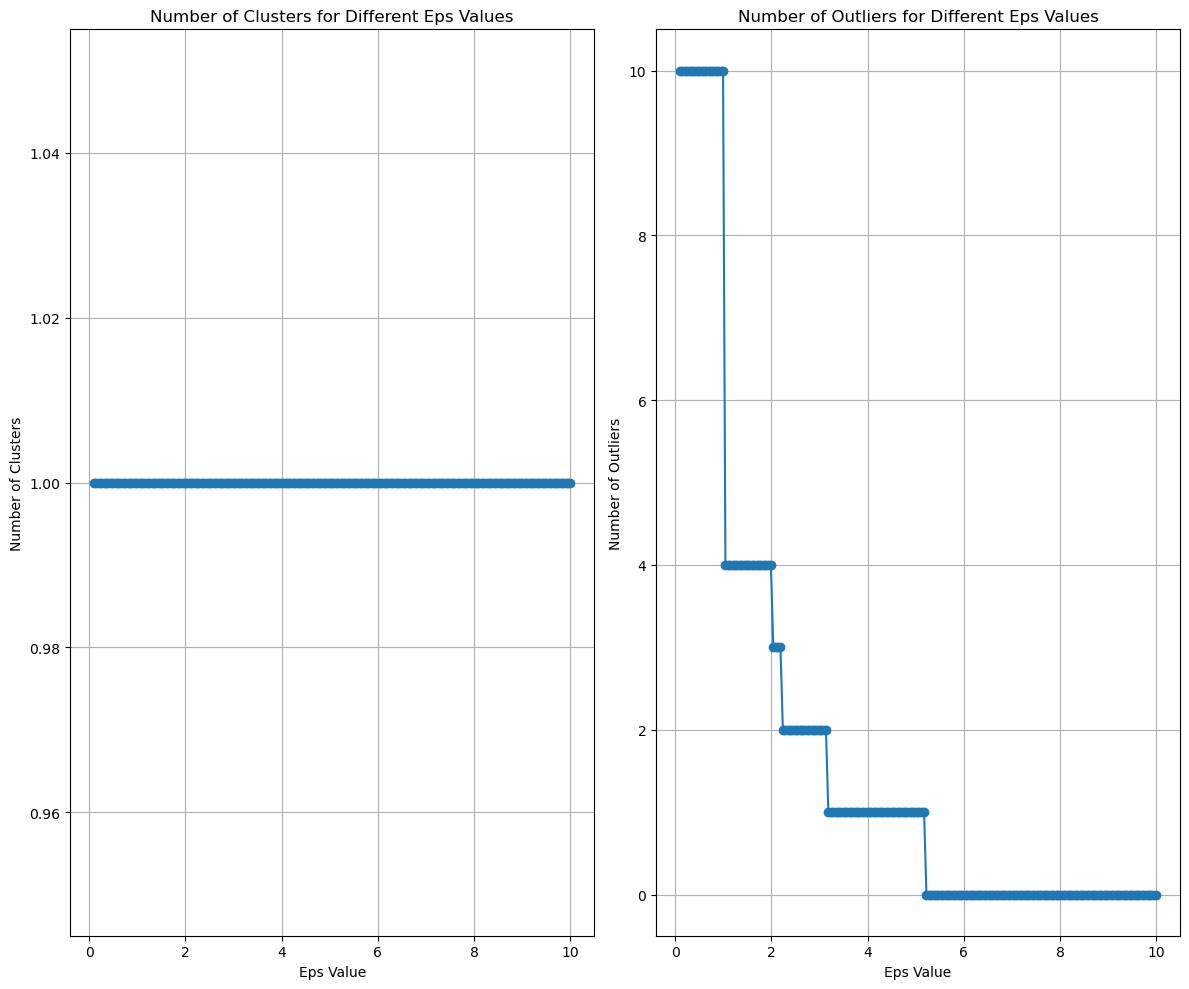

In [266]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_sa_ba)

In [267]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(data_sa_ba)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 1


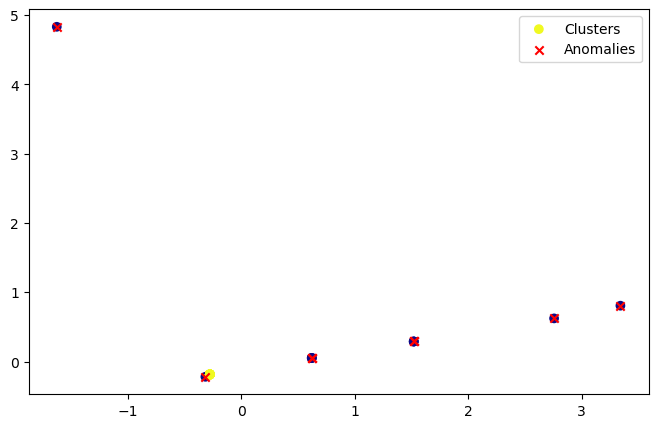

In [268]:
draw_clusters(data_sa_ba, cluster_labels, is_anomaly)

In [269]:
count_points_in_clusters(cluster_labels)

Кластер 0: 38 точек
Кластер -1: 10 точек


In [270]:
analyze_clusters(data_sa_ba, cluster_labels, sa_ba_df.columns)

Кластер -1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['greenplum', 'miro', 'selenium', 'tableau', 'uml'], dtype='object')

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['miro', 'power bi', 'selenium', 'tableau', 'uml'], dtype='object')



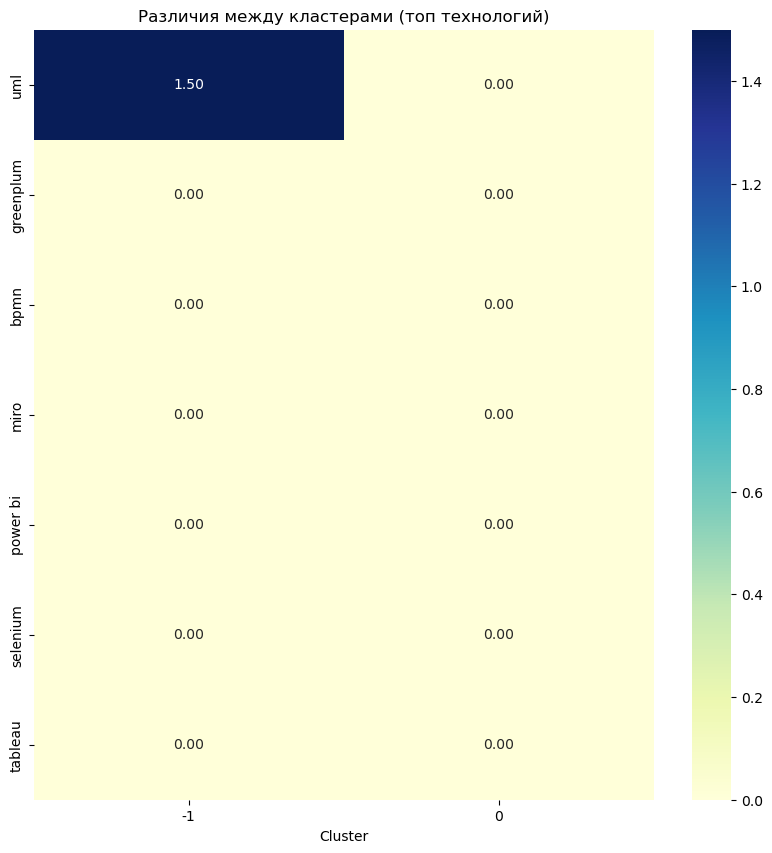

In [271]:
draw_heat_map(data_sa_ba, sa_ba_df.columns, cluster_labels) 

UML, miro, power bi

## SA BA Anomalies

In [272]:
sa_ba_anomalies = sa_ba_df[is_anomaly]
sa_ba_anomalies.head()

,greenplum,bpmn,miro,power bi,selenium,tableau,uml
24,0,0,0,2,0,0,0
32,0,0,0,0,3,0,3
87,0,0,0,0,0,0,1
102,0,0,0,0,0,0,2
114,3,0,3,0,0,3,0


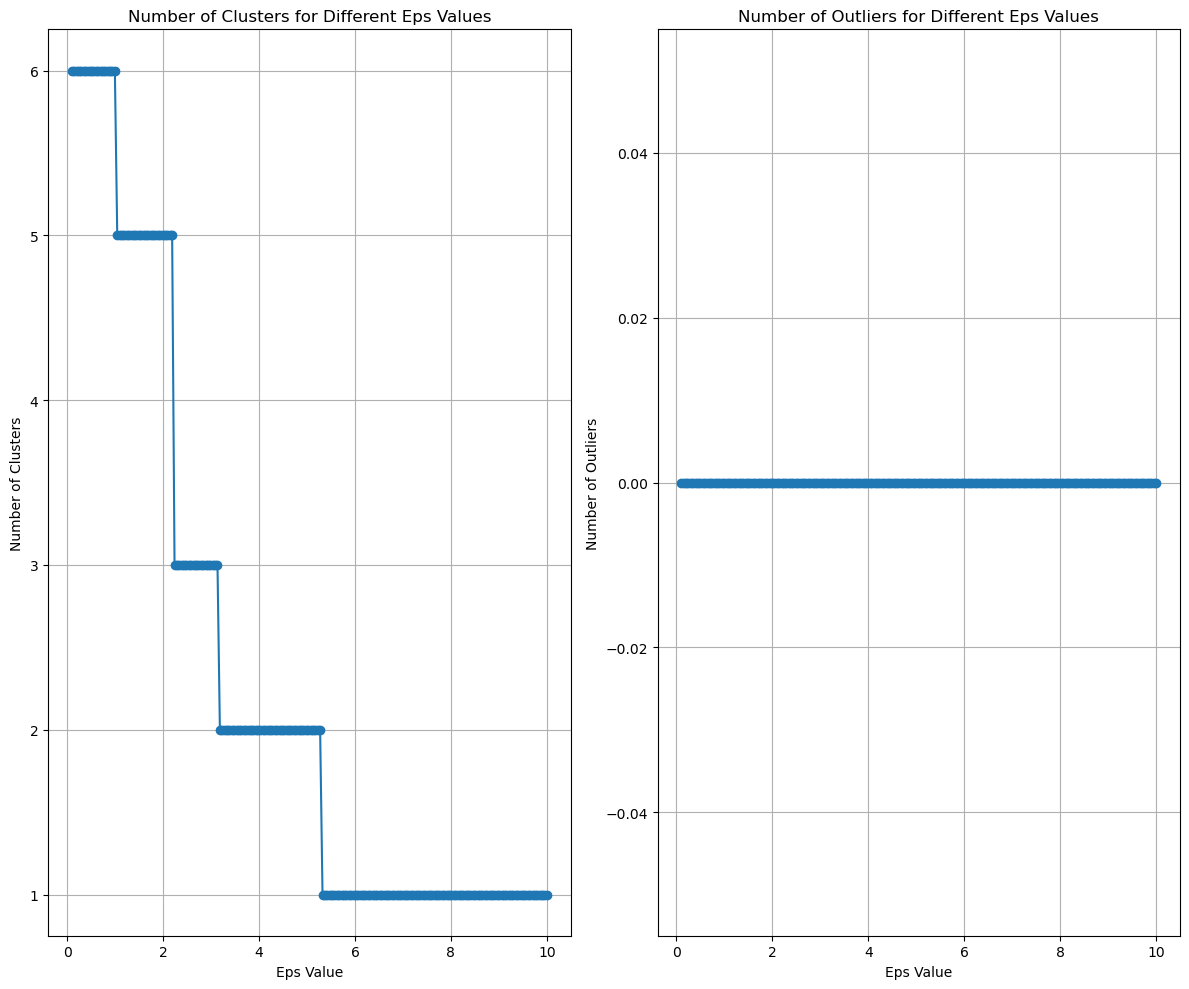

In [273]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, sa_ba_anomalies, 1)

In [274]:
dbscan = DBSCAN(eps=4, min_samples=1)
dbscan.fit(sa_ba_anomalies)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 2


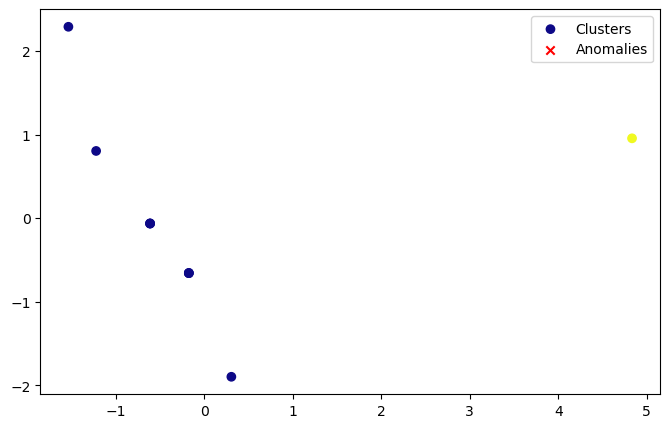

In [275]:
draw_clusters(sa_ba_anomalies, cluster_labels, is_anomaly)

In [276]:
count_points_in_clusters(cluster_labels)

Кластер 0: 9 точек
Кластер 1: 1 точек


In [277]:
analyze_clusters(sa_ba_anomalies, cluster_labels, sa_ba_anomalies.columns)

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['tableau', 'bpmn', 'power bi', 'selenium', 'uml'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['selenium', 'uml', 'greenplum', 'miro', 'tableau'], dtype='object')



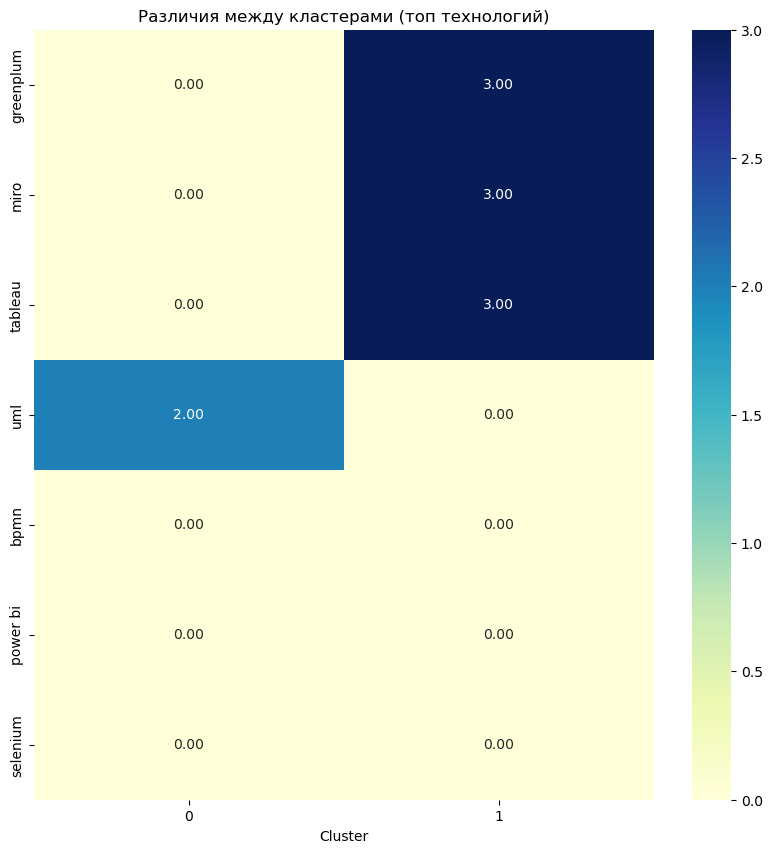

In [278]:
draw_heat_map(sa_ba_anomalies, sa_ba_anomalies.columns, cluster_labels, 25)

**Выводы по BA/SA**: greenplum?, miro, tableau, uml, power bi, bpmn, selenium

# QA

In [279]:
qa_df = result_df[result_df['roles'].str.contains('qa')]
qa_df.head()

,"Единая учетная запись СПбГУ (например, ST000000)","Языки программирования (например: C++, Python, Java, etc)","Библиотеки и фреймворки для различных направлений использования (например: Qt, Numpy, Weka, Angular, PyTorch, etc)","Инструменты для проектирования, бизнес и системного анализа (например: BPMN, UML, Archimate, ARIS etc)","Инструменты для разработки ПО - например: VS Code, PyCharm, Git, etc)","Инструменты для тестирования (например: GTests, Selenium, Gatling, pytest etc)","Инструменты CI / CD (например: Jenkins, Travis CI, Docker, etc)","Инструменты для управления проектами (например: Jira, Trello, MS Project, etc)","Выберете интересующие Вас роли, в IT [Бизнес и системный анализ]","Выберете интересующие Вас роли, в IT [Дизайн UX / UI и проектирование интерфейсов]",...,spring,cg,github cli,azure,krl,next.js,pyhton,unity dots,redux,jupyter lab
29,ST105895,С++ - 4\nPython - 2,Vue - 1\nNumpy - 2\nPandas - 2\nAsio - 1,nan,VS code - 3\nVisual Studio - 4\nGit - 4,nan,nan,nan,3,1,...,0,0,0,0,0,0,0,0,0,0
45,ST097831,Python - 3\nR - 2\nJavaScript - 2\nС# - 1,Numpy - 3\nPandas - 3,nan,VS Code - 3\nGit - 3,pytest - 3,Docker - 2,Trello - 5\nJira - 2,3,5,...,0,0,0,0,0,0,0,0,0,0
60,ST110625,Python - 2,Numpy - 1,nan,nan,nan,nan,nan,5,1,...,0,0,0,0,0,0,0,0,0,0
63,ST115977,Python - 3\nC++ - 2,Numpy - 2\nPyTorch - 2\nFlask - 3,BPMN - 2,PyCharm - 3\nVisual Studio - 3,nan,Docker - 1,Jira - 1\nTrello - 1,1,1,...,0,0,0,0,0,0,0,0,0,0
89,ST087238,C++ - 2\nPython - 1\nJava - 1,nan,nan,nan,nan,nan,nan,1,1,...,0,0,0,0,0,0,0,0,0,0


In [280]:
# qa_techs = []
# with open("test_tools.txt", "r") as file:
#     qa_techs = file.read().splitlines()

In [281]:
# qa_df = qa_df.drop(tech_columns, axis=1) 
# qa_df = qa_df.drop(['Единая учетная запись СПбГУ (например, ST000000)'], axis=1)
# qa_df = qa_df.drop(role_columns, axis=1)
qa_df = qa_df[qa_techs]

In [282]:
qa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 29 to 347
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   chai              36 non-null     int64
 1   xcode simulator   36 non-null     int64
 2   heroku            36 non-null     int64
 3   rspec             36 non-null     int64
 4   gatling           36 non-null     int64
 5   yandex tank       36 non-null     int64
 6   gatiling          36 non-null     int64
 7   jasmine           36 non-null     int64
 8   gotest            36 non-null     int64
 9   robot framework   36 non-null     int64
 10  cpputest          36 non-null     int64
 11  selenium          36 non-null     int64
 12  puppeteer         36 non-null     int64
 13  gtest             36 non-null     int64
 14  junit             36 non-null     int64
 15  seleniun          36 non-null     int64
 16  android espresso  36 non-null     int64
 17  mocha             36 non-null     i

In [283]:
# qa_df = qa_df.drop(['pycharm', 'numpy', 'vscode', 'visual studio', 'vs code', 'pandas', 'trello', 'c++', 'python', 'docker', 'git', 'java'], axis=1) 

In [284]:
qa_df = drop_zero_columns(qa_df)

data_qa = qa_df.values

Колонки с нулевыми значениями: ['chai', 'xcode simulator', 'heroku', 'rspec', 'gatling', 'yandex tank', 'gatiling', 'jasmine', 'gotest', 'robot framework', 'cpputest', 'puppeteer', 'gtest', 'junit', 'seleniun', 'android espresso', 'mocha', 'polyfactory', 'mokito', 'pytest-xdist', 'freezegun', 'unittest', 'karma', 'capybara', 'gohit', 'faker', 'jest', 'bomardier', 's', '.', 'thunder client', 'stryker', 'shinon', 'cypress', 'mutmut', 'google test', 'nightwatch', 'hypothesis', 'backstop', 'locust', 'scalatest', 'mockito']


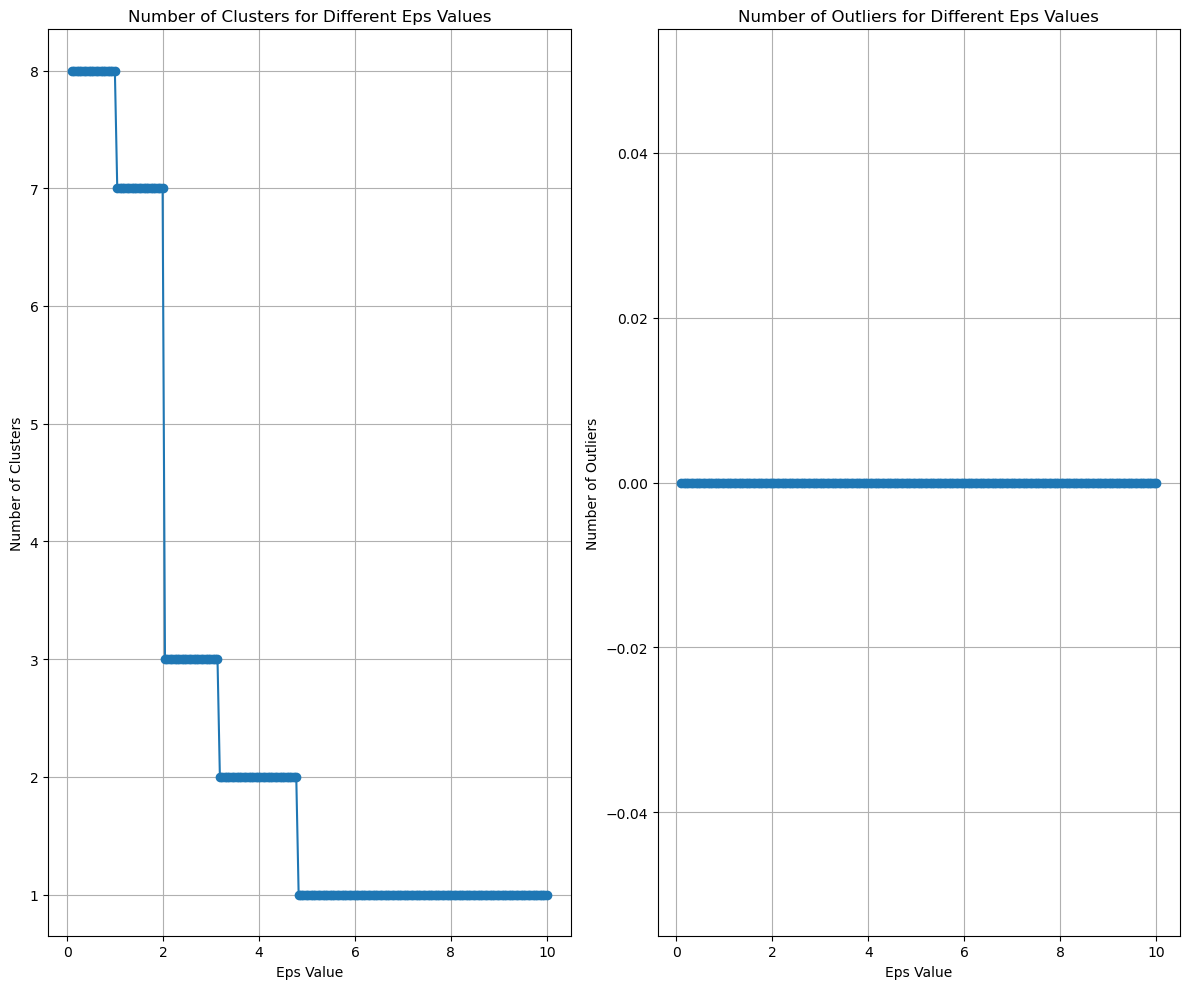

In [285]:
find_parameters_for_DBSCUN(0.1, 10.0, 200, data_qa, 1)

In [286]:
dbscan = DBSCAN(eps=2, min_samples=1)
dbscan.fit(data_qa)

# Метки кластеров (набор целых чисел, -1 означает выбросы)
cluster_labels = dbscan.labels_

# Метка аномалий (True/False)
is_anomaly = cluster_labels == -1

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print("Количество кластеров:", n_clusters)

Количество кластеров: 3


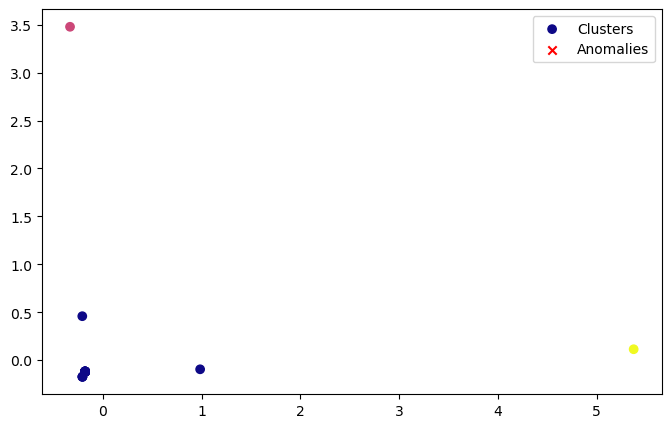

In [287]:
draw_clusters(data_qa, cluster_labels, is_anomaly)

In [288]:
analyze_clusters(data_qa, cluster_labels, qa_df.columns)

Кластер 0:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['jira', 'selenium', 'c#unit test', 'gtests', 'nunit'], dtype='object')

Кластер 1:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['postman', 'xunit', 'django', 'jira', 'pytest'], dtype='object')

Кластер 2:
Топ-10 колонок с наибольшими максимальными значениями:
Index(['jira', 'django', 'nunit', 'postman', 'xunit'], dtype='object')



Кластер 0: 34 точек
Кластер 1: 1 точек
Кластер 2: 1 точек


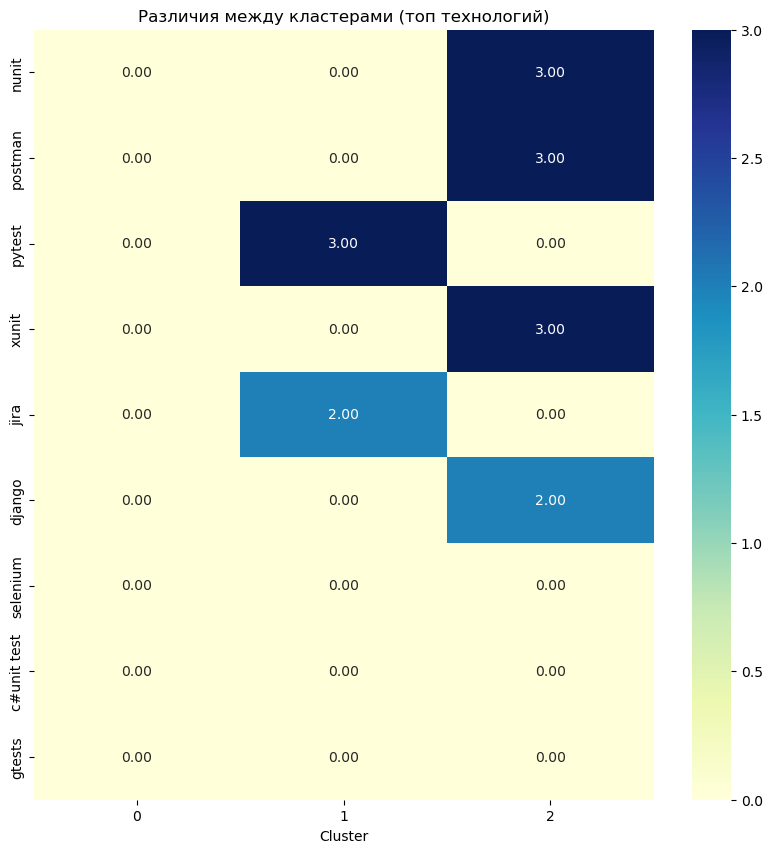

In [289]:
count_points_in_clusters(cluster_labels)
draw_heat_map(data_qa, qa_df.columns, cluster_labels, 30) 

**Вывод по QA:** nunit, postman, pytest, xunit, selenium, c#unit test, gtests


# Выводы

1. На ПМ-ПУ знают Python и С++ (Джентельменский набор: C++, Python, Numpy, VS Code, Git, Docker)

2. 
    * 'implementation': docker, github actions, jenkins, travis ci, kubernetes, gitea,  aws cloudfornation?  
    * 'ux/ui': 
        * java, c#, 
        * java, JS, React, mobx, redux
        * Xcode, swift, objective-c, cocoa, cocoa touch?
        * c++ + qt
    * 'backend developer': основная масса желающих знает **Python** (+Fastapi, flask), **C++**, изредка встречаются java/kotlin (+spring), C#, JS + react, Swift/Objective-C, sqlalchemy, redux.  [ Python + numpy, C++, java, c#, java ]
    * 'system or business analyst': greenplum?, miro, tableau, uml, power bi, bpmn, selenium
    * 'qa': nunit, postman, pytest, xunit, selenium, c#unit test, gtests
    * 'frontend developer': Python + Numpy, C++; специфичные: java; характерные технологии JS/TypeScript, React/VueJS,  Java, (python), java spring, redux
    * 'da or de': Python + numpy + pandas + pytorch + scipy + matplotlib ((folium, asana, jupiter lab)), nltk, (c++, docker, java).
    * 'pm': популярны trello, jira, confluence, miro, clickup, mindmeister, coggle, notion

## Какие дополнительные score можно сделать на основе этих списков?